## Mount Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [33]:
import os
import cv2
import glob
import torch
import random
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as patches
from albumentations.pytorch import ToTensorV2
from torchvision.models import ResNet34_Weights
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_curve, average_precision_score

## Reading data and visualising

In [34]:
def read_image(image_path, grayscale=False):
    if grayscale:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def masks_to_boxes(mask):
    unique_values = np.unique(mask)
    unique_values = unique_values[unique_values != 0] # 0 is the background

    bboxes = []

    for val in unique_values:
        binary_mask = (mask == val).astype(np.uint8)

        rows, cols = np.where(binary_mask)

        if len(rows) == 0 or len(cols) == 0:
            continue

        x_min, x_max = np.min(cols), np.max(cols)
        y_min, y_max = np.min(rows), np.max(rows)

        w = x_max - x_min + 1
        h = y_max - y_min + 1

        bboxes.append([x_min, y_min, w, h])

    return bboxes

def draw_bboxes(image, bboxes):
    image_copy = image.copy()

    if len(image_copy.shape) == 2:
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_GRAY2RGB)

    # image_copy = image_copy.astype(np.uint8)

    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_copy

path_to_data = "/content/drive/MyDrive/cv_a3/shared_data/Q2/detection"

n_images_to_visualise = 5

train_split = 0.8

# Reading Data
train_image_names = [f for f in os.listdir(f"{path_to_data}/train/images") if f.lower().endswith(('.png'))]
train_image_names, val_image_names = train_image_names[:int(len(train_image_names) * train_split)], train_image_names[int(len(train_image_names) * train_split):]

train_image_paths = [f"{path_to_data}/train/images/{image_name}" for image_name in train_image_names]
train_images = [read_image(image_path) for image_path in train_image_paths]
print(f"Number of train images = {len(train_images)}")

val_image_paths = [f"{path_to_data}/train/images/{image_name}" for image_name in val_image_names]
val_images = [read_image(image_path) for image_path in val_image_paths]
print(f"Number of val images = {len(val_images)}")

train_mask_paths = [f"{path_to_data}/train/masks/{image_name}" for image_name in train_image_names]
train_masks = [read_image(mask_path, grayscale=True) for mask_path in train_mask_paths]
print(f"Number of train masks = {len(train_masks)}")

val_mask_paths = [f"{path_to_data}/train/masks/{image_name}" for image_name in val_image_names]
val_masks = [read_image(mask_path, grayscale=True) for mask_path in val_mask_paths]
print(f"Number of val masks = {len(val_masks)}")

Number of train images = 536
Number of val images = 134
Number of train masks = 536
Number of val masks = 134


Number of train Bounding Boxes = 536
Number of val Bounding Boxes = 134
Bounding boxes converted to Pascal VOC type


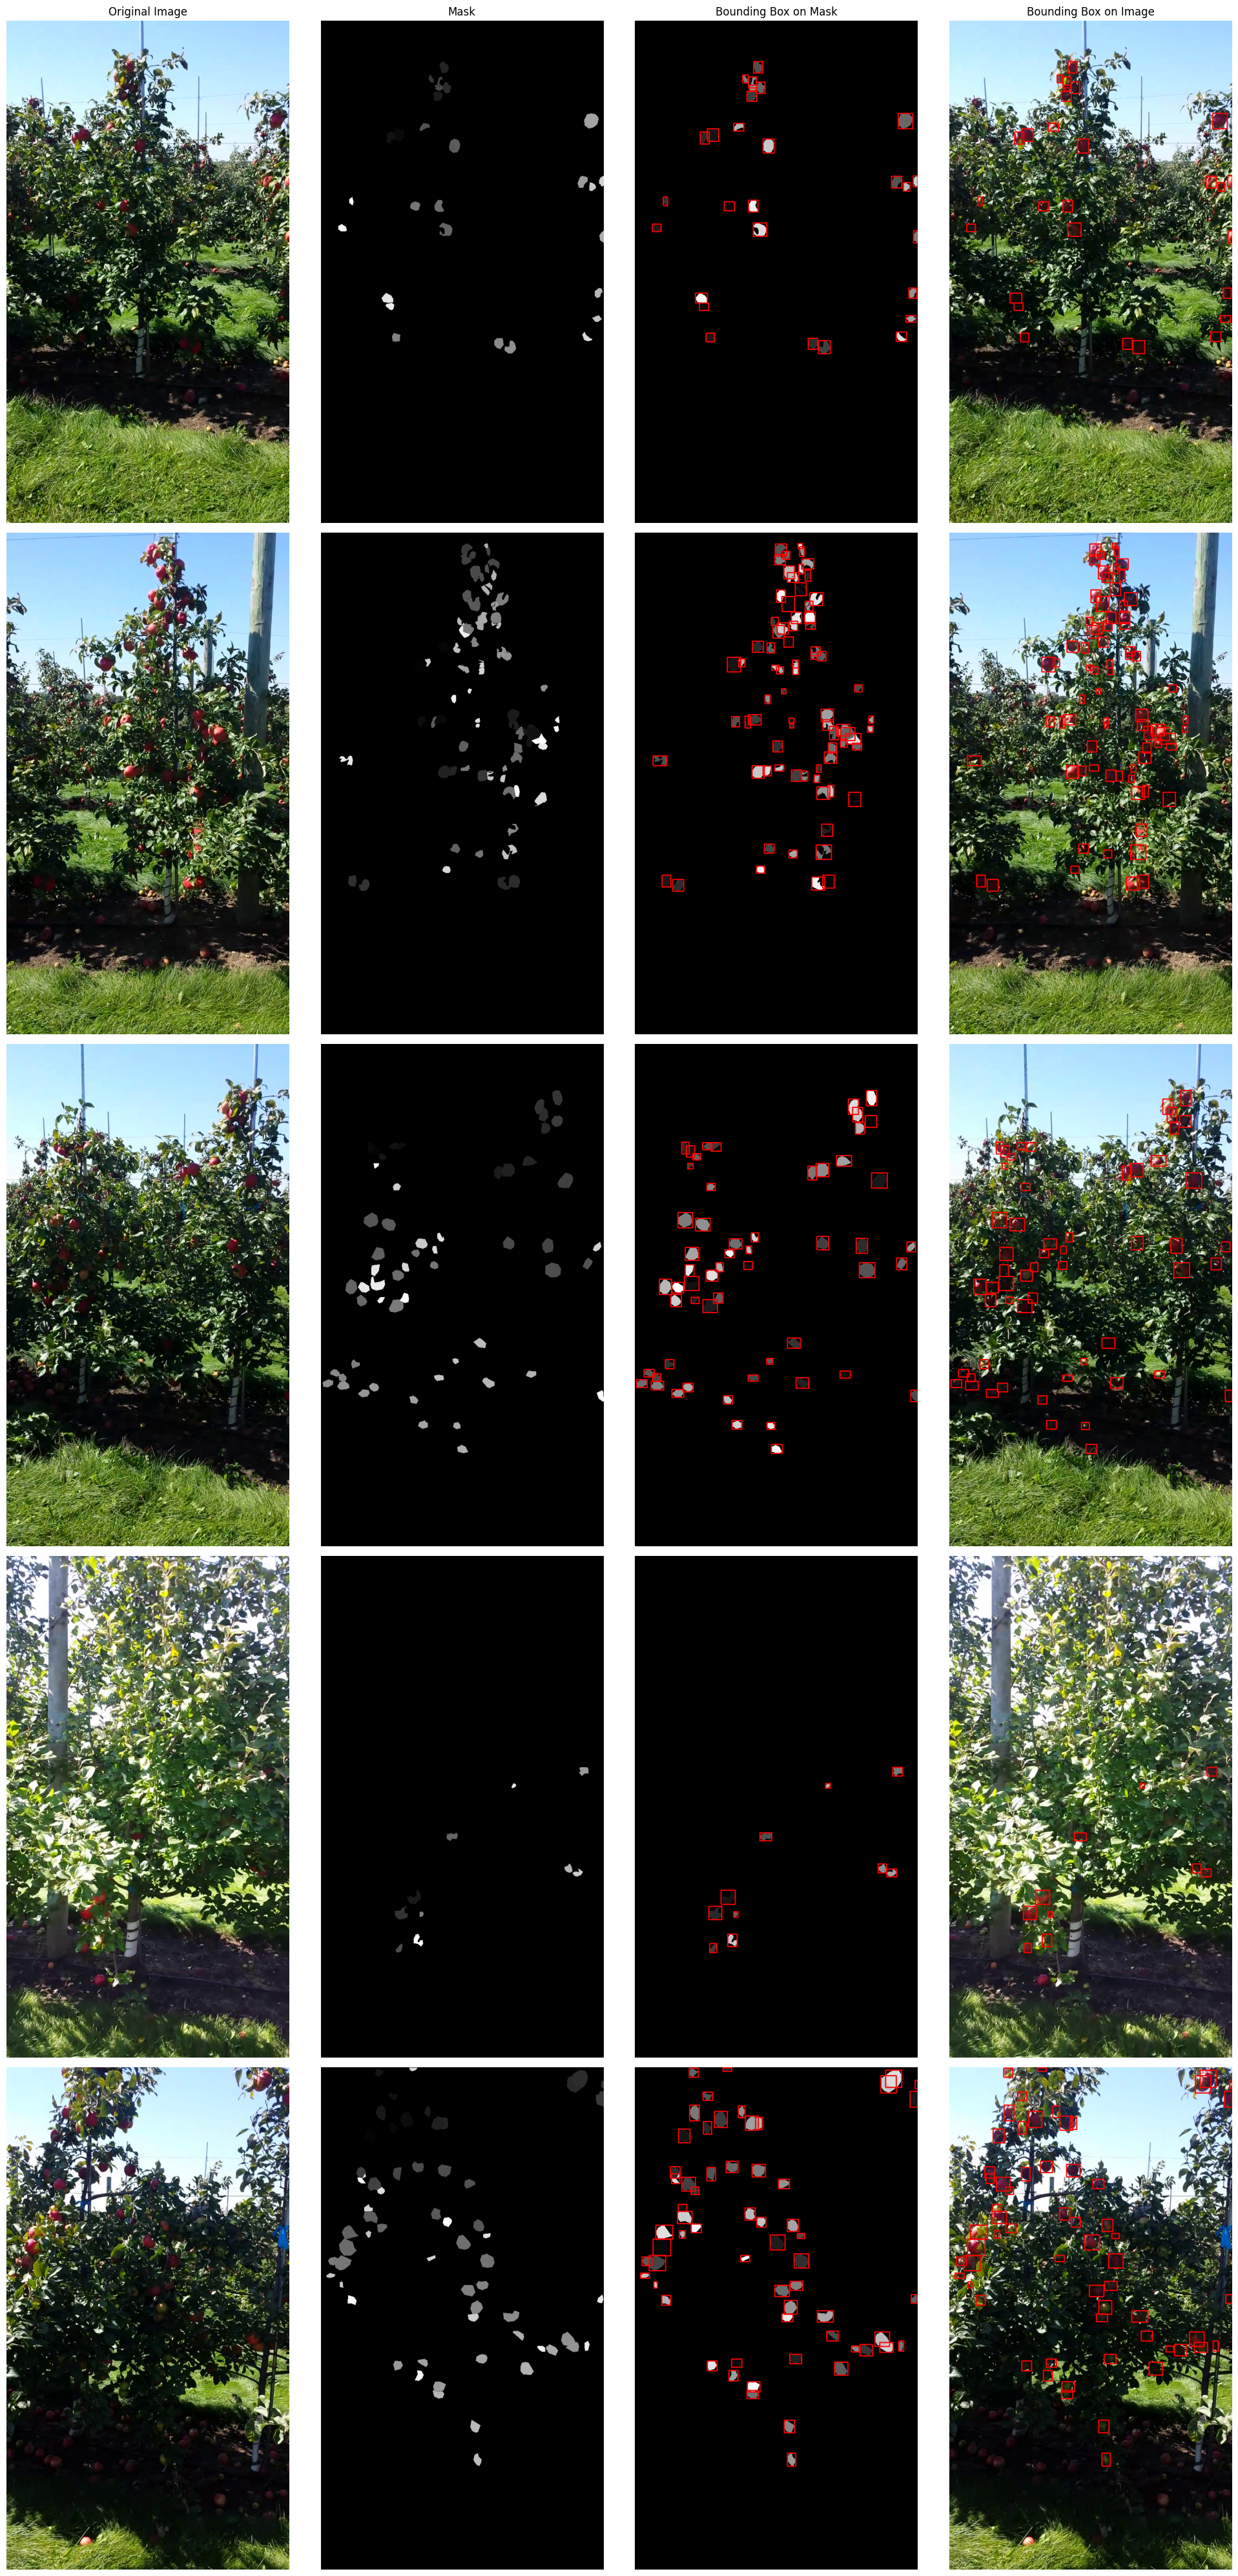

In [35]:
# Converting all masks to Bboxes
train_bboxes = [masks_to_boxes(mask) for mask in train_masks]
print(f"Number of train Bounding Boxes = {len(train_bboxes)}")
val_bboxes = [masks_to_boxes(mask) for mask in val_masks]
print(f"Number of val Bounding Boxes = {len(val_bboxes)}")

train_bboxes_pascal = []
for per_img_bboxes in train_bboxes:
    this_img_pascal_bboxes = []
    for bbox in per_img_bboxes:
        x, y, w, h = bbox
        this_img_pascal_bboxes.append([x, y, x + w, y + h])
    train_bboxes_pascal.append(this_img_pascal_bboxes)

val_bboxes_pascal = []
for per_img_bboxes in val_bboxes:
    this_img_pascal_bboxes = []
    for bbox in per_img_bboxes:
        x, y, w, h = bbox
        this_img_pascal_bboxes.append([x, y, x + w, y + h])
    val_bboxes_pascal.append(this_img_pascal_bboxes)
print("Bounding boxes converted to Pascal VOC type")

# Plotting to visualise
fig, axes = plt.subplots(n_images_to_visualise, 4, figsize=(20, 40))

for i in range(n_images_to_visualise):
    image = train_images[i]
    mask = train_masks[i]
    bboxes = train_bboxes[i]

    axes[i][0].imshow(image)
    axes[i][0].axis("off")

    axes[i][1].imshow(mask, cmap="gray")
    axes[i][1].axis("off")

    axes[i][2].imshow(draw_bboxes(np.clip(mask * 20, 0, 255), bboxes))
    axes[i][2].axis("off")

    axes[i][3].imshow(draw_bboxes(image, bboxes))
    axes[i][3].axis("off")

    if i == 0:  # Only display the titles for the first row
        axes[i][0].set_title("Original Image")
        axes[i][1].set_title("Mask")
        axes[i][2].set_title("Bounding Box on Mask")
        axes[i][3].set_title("Bounding Box on Image")

plt.tight_layout()
plt.show()

## Dataset Class

In [36]:
MEAN = (0.485, 0.456, 0.406)
STD_DEV = (0.229, 0.224, 0.225)

def get_transform(train=True):
    if train:
        return A.Compose([
            # Geometric transforms
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5),
            # Color transforms
            # A.ColorJitter(
            #     brightness=0.2,
            #     contrast=0.2,
            #     saturation=0.2,
            #     hue=0.1,
            #     p=0.7
            # ),
            # Normalization and tensor conversion
            A.Normalize(mean=MEAN, std=STD_DEV),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels'],
            min_visibility=0.1
        ))
    else:
        return A.Compose([
            A.Normalize(mean=MEAN, std=STD_DEV),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels'],
            min_visibility=0.1
        ))

class FruitDetectionDataset(Dataset):
    def __init__(self, images, bboxes, transforms=None):
        self.images = images
        # self.masks = masks
        self.bboxes = bboxes
        self.transforms = transforms
        self.classes = ['background', 'fruit']

        self.label2idx = {self.classes[idx]: idx for idx in range(len(self.classes))}
        self.idx2label = {idx: self.classes[idx] for idx in range(len(self.classes))}

        print(self.idx2label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        bboxes = self.bboxes[idx]

        labels = [1] * len(bboxes)
        target = {"boxes": bboxes, "labels": labels}

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels) # All Bboxes refers to class fruit (label = 1)
            img = transformed['image']
            target["boxes"] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target["labels"] = torch.as_tensor(transformed['labels'], dtype=torch.int64)  # Ensure transformed labels are tensors

        return img, target

## Select Device

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Imports from Q1 Detection folder (Copy Paste of each file)

In [38]:
# _UTILS
import math
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss, FrozenBatchNorm2d, generalized_box_iou_loss


class BalancedPositiveNegativeSampler:
    """
    This class samples batches, ensuring that they contain a fixed proportion of positives
    """

    def __init__(self, batch_size_per_image: int, positive_fraction: float) -> None:
        """
        Args:
            batch_size_per_image (int): number of elements to be selected per image
            positive_fraction (float): percentage of positive elements per batch
        """
        self.batch_size_per_image = batch_size_per_image
        self.positive_fraction = positive_fraction

    def __call__(self, matched_idxs: List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]:
        """
        Args:
            matched_idxs: list of tensors containing -1, 0 or positive values.
                Each tensor corresponds to a specific image.
                -1 values are ignored, 0 are considered as negatives and > 0 as
                positives.

        Returns:
            pos_idx (list[tensor])
            neg_idx (list[tensor])

        Returns two lists of binary masks for each image.
        The first list contains the positive elements that were selected,
        and the second list the negative example.
        """
        pos_idx = []
        neg_idx = []
        for matched_idxs_per_image in matched_idxs:
            positive = torch.where(matched_idxs_per_image >= 1)[0]
            negative = torch.where(matched_idxs_per_image == 0)[0]

            num_pos = int(self.batch_size_per_image * self.positive_fraction)
            # protect against not enough positive examples
            num_pos = min(positive.numel(), num_pos)
            num_neg = self.batch_size_per_image - num_pos
            # protect against not enough negative examples
            num_neg = min(negative.numel(), num_neg)

            # randomly select positive and negative examples
            perm1 = torch.randperm(positive.numel(), device=positive.device)[:num_pos]
            perm2 = torch.randperm(negative.numel(), device=negative.device)[:num_neg]

            pos_idx_per_image = positive[perm1]
            neg_idx_per_image = negative[perm2]

            # create binary mask from indices
            pos_idx_per_image_mask = torch.zeros_like(matched_idxs_per_image, dtype=torch.uint8)
            neg_idx_per_image_mask = torch.zeros_like(matched_idxs_per_image, dtype=torch.uint8)

            pos_idx_per_image_mask[pos_idx_per_image] = 1
            neg_idx_per_image_mask[neg_idx_per_image] = 1

            pos_idx.append(pos_idx_per_image_mask)
            neg_idx.append(neg_idx_per_image_mask)

        return pos_idx, neg_idx


@torch.jit._script_if_tracing
def encode_boxes(reference_boxes: Tensor, proposals: Tensor, weights: Tensor) -> Tensor:
    """
    Encode a set of proposals with respect to some
    reference boxes

    Args:
        reference_boxes (Tensor): reference boxes
        proposals (Tensor): boxes to be encoded
        weights (Tensor[4]): the weights for ``(x, y, w, h)``
    """

    # perform some unpacking to make it JIT-fusion friendly
    wx = weights[0]
    wy = weights[1]
    ww = weights[2]
    wh = weights[3]

    proposals_x1 = proposals[:, 0].unsqueeze(1)
    proposals_y1 = proposals[:, 1].unsqueeze(1)
    proposals_x2 = proposals[:, 2].unsqueeze(1)
    proposals_y2 = proposals[:, 3].unsqueeze(1)

    reference_boxes_x1 = reference_boxes[:, 0].unsqueeze(1)
    reference_boxes_y1 = reference_boxes[:, 1].unsqueeze(1)
    reference_boxes_x2 = reference_boxes[:, 2].unsqueeze(1)
    reference_boxes_y2 = reference_boxes[:, 3].unsqueeze(1)

    # implementation starts here
    ex_widths = proposals_x2 - proposals_x1
    ex_heights = proposals_y2 - proposals_y1
    ex_ctr_x = proposals_x1 + 0.5 * ex_widths
    ex_ctr_y = proposals_y1 + 0.5 * ex_heights

    gt_widths = reference_boxes_x2 - reference_boxes_x1
    gt_heights = reference_boxes_y2 - reference_boxes_y1
    gt_ctr_x = reference_boxes_x1 + 0.5 * gt_widths
    gt_ctr_y = reference_boxes_y1 + 0.5 * gt_heights

    targets_dx = wx * (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = wy * (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = ww * torch.log(gt_widths / ex_widths)
    targets_dh = wh * torch.log(gt_heights / ex_heights)

    targets = torch.cat((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets


class BoxCoder:
    """
    This class encodes and decodes a set of bounding boxes into
    the representation used for training the regressors.
    """

    def __init__(
        self, weights: Tuple[float, float, float, float], bbox_xform_clip: float = math.log(1000.0 / 16)
    ) -> None:
        """
        Args:
            weights (4-element tuple)
            bbox_xform_clip (float)
        """
        self.weights = weights
        self.bbox_xform_clip = bbox_xform_clip

    def encode(self, reference_boxes: List[Tensor], proposals: List[Tensor]) -> List[Tensor]:
        boxes_per_image = [len(b) for b in reference_boxes]
        reference_boxes = torch.cat(reference_boxes, dim=0)
        proposals = torch.cat(proposals, dim=0)
        targets = self.encode_single(reference_boxes, proposals)
        return targets.split(boxes_per_image, 0)

    def encode_single(self, reference_boxes: Tensor, proposals: Tensor) -> Tensor:
        """
        Encode a set of proposals with respect to some
        reference boxes

        Args:
            reference_boxes (Tensor): reference boxes
            proposals (Tensor): boxes to be encoded
        """
        dtype = reference_boxes.dtype
        device = reference_boxes.device
        weights = torch.as_tensor(self.weights, dtype=dtype, device=device)
        targets = encode_boxes(reference_boxes, proposals, weights)

        return targets

    def decode(self, rel_codes: Tensor, boxes: List[Tensor]) -> Tensor:
        torch._assert(
            isinstance(boxes, (list, tuple)),
            "This function expects boxes of type list or tuple.",
        )
        torch._assert(
            isinstance(rel_codes, torch.Tensor),
            "This function expects rel_codes of type torch.Tensor.",
        )
        boxes_per_image = [b.size(0) for b in boxes]
        concat_boxes = torch.cat(boxes, dim=0)
        box_sum = 0
        for val in boxes_per_image:
            box_sum += val
        if box_sum > 0:
            rel_codes = rel_codes.reshape(box_sum, -1)
        pred_boxes = self.decode_single(rel_codes, concat_boxes)
        if box_sum > 0:
            pred_boxes = pred_boxes.reshape(box_sum, -1, 4)
        return pred_boxes

    def decode_single(self, rel_codes: Tensor, boxes: Tensor) -> Tensor:
        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.

        Args:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.
        """

        boxes = boxes.to(rel_codes.dtype)

        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = self.weights
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        # Prevent sending too large values into torch.exp()
        dw = torch.clamp(dw, max=self.bbox_xform_clip)
        dh = torch.clamp(dh, max=self.bbox_xform_clip)

        pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
        pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]

        # Distance from center to box's corner.
        c_to_c_h = torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_h.device) * pred_h
        c_to_c_w = torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_w.device) * pred_w

        pred_boxes1 = pred_ctr_x - c_to_c_w
        pred_boxes2 = pred_ctr_y - c_to_c_h
        pred_boxes3 = pred_ctr_x + c_to_c_w
        pred_boxes4 = pred_ctr_y + c_to_c_h
        pred_boxes = torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=2).flatten(1)
        return pred_boxes


class BoxLinearCoder:
    """
    The linear box-to-box transform defined in FCOS. The transformation is parameterized
    by the distance from the center of (square) src box to 4 edges of the target box.
    """

    def __init__(self, normalize_by_size: bool = True) -> None:
        """
        Args:
            normalize_by_size (bool): normalize deltas by the size of src (anchor) boxes.
        """
        self.normalize_by_size = normalize_by_size

    def encode(self, reference_boxes: Tensor, proposals: Tensor) -> Tensor:
        """
        Encode a set of proposals with respect to some reference boxes

        Args:
            reference_boxes (Tensor): reference boxes
            proposals (Tensor): boxes to be encoded

        Returns:
            Tensor: the encoded relative box offsets that can be used to
            decode the boxes.

        """

        # get the center of reference_boxes
        reference_boxes_ctr_x = 0.5 * (reference_boxes[..., 0] + reference_boxes[..., 2])
        reference_boxes_ctr_y = 0.5 * (reference_boxes[..., 1] + reference_boxes[..., 3])

        # get box regression transformation deltas
        target_l = reference_boxes_ctr_x - proposals[..., 0]
        target_t = reference_boxes_ctr_y - proposals[..., 1]
        target_r = proposals[..., 2] - reference_boxes_ctr_x
        target_b = proposals[..., 3] - reference_boxes_ctr_y

        targets = torch.stack((target_l, target_t, target_r, target_b), dim=-1)

        if self.normalize_by_size:
            reference_boxes_w = reference_boxes[..., 2] - reference_boxes[..., 0]
            reference_boxes_h = reference_boxes[..., 3] - reference_boxes[..., 1]
            reference_boxes_size = torch.stack(
                (reference_boxes_w, reference_boxes_h, reference_boxes_w, reference_boxes_h), dim=-1
            )
            targets = targets / reference_boxes_size
        return targets

    def decode(self, rel_codes: Tensor, boxes: Tensor) -> Tensor:

        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.

        Args:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.

        Returns:
            Tensor: the predicted boxes with the encoded relative box offsets.

        .. note::
            This method assumes that ``rel_codes`` and ``boxes`` have same size for 0th dimension. i.e. ``len(rel_codes) == len(boxes)``.

        """

        boxes = boxes.to(dtype=rel_codes.dtype)

        ctr_x = 0.5 * (boxes[..., 0] + boxes[..., 2])
        ctr_y = 0.5 * (boxes[..., 1] + boxes[..., 3])

        if self.normalize_by_size:
            boxes_w = boxes[..., 2] - boxes[..., 0]
            boxes_h = boxes[..., 3] - boxes[..., 1]

            list_box_size = torch.stack((boxes_w, boxes_h, boxes_w, boxes_h), dim=-1)
            rel_codes = rel_codes * list_box_size

        pred_boxes1 = ctr_x - rel_codes[..., 0]
        pred_boxes2 = ctr_y - rel_codes[..., 1]
        pred_boxes3 = ctr_x + rel_codes[..., 2]
        pred_boxes4 = ctr_y + rel_codes[..., 3]

        pred_boxes = torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=-1)
        return pred_boxes


class Matcher:
    """
    This class assigns to each predicted "element" (e.g., a box) a ground-truth
    element. Each predicted element will have exactly zero or one matches; each
    ground-truth element may be assigned to zero or more predicted elements.

    Matching is based on the MxN match_quality_matrix, that characterizes how well
    each (ground-truth, predicted)-pair match. For example, if the elements are
    boxes, the matrix may contain box IoU overlap values.

    The matcher returns a tensor of size N containing the index of the ground-truth
    element m that matches to prediction n. If there is no match, a negative value
    is returned.
    """

    BELOW_LOW_THRESHOLD = -1
    BETWEEN_THRESHOLDS = -2

    __annotations__ = {
        "BELOW_LOW_THRESHOLD": int,
        "BETWEEN_THRESHOLDS": int,
    }

    def __init__(self, high_threshold: float, low_threshold: float, allow_low_quality_matches: bool = False) -> None:
        """
        Args:
            high_threshold (float): quality values greater than or equal to
                this value are candidate matches.
            low_threshold (float): a lower quality threshold used to stratify
                matches into three levels:
                1) matches >= high_threshold
                2) BETWEEN_THRESHOLDS matches in [low_threshold, high_threshold)
                3) BELOW_LOW_THRESHOLD matches in [0, low_threshold)
            allow_low_quality_matches (bool): if True, produce additional matches
                for predictions that have only low-quality match candidates. See
                set_low_quality_matches_ for more details.
        """
        self.BELOW_LOW_THRESHOLD = -1
        self.BETWEEN_THRESHOLDS = -2
        torch._assert(low_threshold <= high_threshold, "low_threshold should be <= high_threshold")
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.allow_low_quality_matches = allow_low_quality_matches

    def __call__(self, match_quality_matrix: Tensor) -> Tensor:
        """
        Args:
            match_quality_matrix (Tensor[float]): an MxN tensor, containing the
            pairwise quality between M ground-truth elements and N predicted elements.

        Returns:
            matches (Tensor[int64]): an N tensor where N[i] is a matched gt in
            [0, M - 1] or a negative value indicating that prediction i could not
            be matched.
        """
        if match_quality_matrix.numel() == 0:
            # empty targets or proposals not supported during training
            if match_quality_matrix.shape[0] == 0:
                raise ValueError("No ground-truth boxes available for one of the images during training")
            else:
                raise ValueError("No proposal boxes available for one of the images during training")

        # match_quality_matrix is M (gt) x N (predicted)
        # Max over gt elements (dim 0) to find best gt candidate for each prediction
        matched_vals, matches = match_quality_matrix.max(dim=0)
        if self.allow_low_quality_matches:
            all_matches = matches.clone()
        else:
            all_matches = None  # type: ignore[assignment]

        # Assign candidate matches with low quality to negative (unassigned) values
        below_low_threshold = matched_vals < self.low_threshold
        between_thresholds = (matched_vals >= self.low_threshold) & (matched_vals < self.high_threshold)
        matches[below_low_threshold] = self.BELOW_LOW_THRESHOLD
        matches[between_thresholds] = self.BETWEEN_THRESHOLDS

        if self.allow_low_quality_matches:
            if all_matches is None:
                torch._assert(False, "all_matches should not be None")
            else:
                self.set_low_quality_matches_(matches, all_matches, match_quality_matrix)

        return matches

    def set_low_quality_matches_(self, matches: Tensor, all_matches: Tensor, match_quality_matrix: Tensor) -> None:
        """
        Produce additional matches for predictions that have only low-quality matches.
        Specifically, for each ground-truth find the set of predictions that have
        maximum overlap with it (including ties); for each prediction in that set, if
        it is unmatched, then match it to the ground-truth with which it has the highest
        quality value.
        """
        # For each gt, find the prediction with which it has the highest quality
        highest_quality_foreach_gt, _ = match_quality_matrix.max(dim=1)
        # Find the highest quality match available, even if it is low, including ties
        gt_pred_pairs_of_highest_quality = torch.where(match_quality_matrix == highest_quality_foreach_gt[:, None])
        # Example gt_pred_pairs_of_highest_quality:
        # (tensor([0, 1, 1, 2, 2, 3, 3, 4, 5, 5]),
        #  tensor([39796, 32055, 32070, 39190, 40255, 40390, 41455, 45470, 45325, 46390]))
        # Each element in the first tensor is a gt index, and each element in second tensor is a prediction index
        # Note how gt items 1, 2, 3, and 5 each have two ties

        pred_inds_to_update = gt_pred_pairs_of_highest_quality[1]
        matches[pred_inds_to_update] = all_matches[pred_inds_to_update]


class SSDMatcher(Matcher):
    def __init__(self, threshold: float) -> None:
        super().__init__(threshold, threshold, allow_low_quality_matches=False)

    def __call__(self, match_quality_matrix: Tensor) -> Tensor:
        matches = super().__call__(match_quality_matrix)

        # For each gt, find the prediction with which it has the highest quality
        _, highest_quality_pred_foreach_gt = match_quality_matrix.max(dim=1)
        matches[highest_quality_pred_foreach_gt] = torch.arange(
            highest_quality_pred_foreach_gt.size(0), dtype=torch.int64, device=highest_quality_pred_foreach_gt.device
        )

        return matches


def overwrite_eps(model: nn.Module, eps: float) -> None:
    """
    This method overwrites the default eps values of all the
    FrozenBatchNorm2d layers of the model with the provided value.
    This is necessary to address the BC-breaking change introduced
    by the bug-fix at pytorch/vision#2933. The overwrite is applied
    only when the pretrained weights are loaded to maintain compatibility
    with previous versions.

    Args:
        model (nn.Module): The model on which we perform the overwrite.
        eps (float): The new value of eps.
    """
    for module in model.modules():
        if isinstance(module, FrozenBatchNorm2d):
            module.eps = eps


def retrieve_out_channels(model: nn.Module, size: Tuple[int, int]) -> List[int]:
    """
    This method retrieves the number of output channels of a specific model.

    Args:
        model (nn.Module): The model for which we estimate the out_channels.
            It should return a single Tensor or an OrderedDict[Tensor].
        size (Tuple[int, int]): The size (wxh) of the input.

    Returns:
        out_channels (List[int]): A list of the output channels of the model.
    """
    in_training = model.training
    model.eval()

    with torch.no_grad():
        # Use dummy data to retrieve the feature map sizes to avoid hard-coding their values
        device = next(model.parameters()).device
        tmp_img = torch.zeros((1, 3, size[1], size[0]), device=device)
        features = model(tmp_img)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        out_channels = [x.size(1) for x in features.values()]

    if in_training:
        model.train()

    return out_channels


@torch.jit.unused
def _fake_cast_onnx(v: Tensor) -> int:
    return v  # type: ignore[return-value]


def _topk_min(input: Tensor, orig_kval: int, axis: int) -> int:
    """
    ONNX spec requires the k-value to be less than or equal to the number of inputs along
    provided dim. Certain models use the number of elements along a particular axis instead of K
    if K exceeds the number of elements along that axis. Previously, python's min() function was
    used to determine whether to use the provided k-value or the specified dim axis value.

    However, in cases where the model is being exported in tracing mode, python min() is
    static causing the model to be traced incorrectly and eventually fail at the topk node.
    In order to avoid this situation, in tracing mode, torch.min() is used instead.

    Args:
        input (Tensor): The original input tensor.
        orig_kval (int): The provided k-value.
        axis(int): Axis along which we retrieve the input size.

    Returns:
        min_kval (int): Appropriately selected k-value.
    """
    if not torch.jit.is_tracing():
        return min(orig_kval, input.size(axis))
    axis_dim_val = torch._shape_as_tensor(input)[axis].unsqueeze(0)
    min_kval = torch.min(torch.cat((torch.tensor([orig_kval], dtype=axis_dim_val.dtype), axis_dim_val), 0))
    return _fake_cast_onnx(min_kval)


def _box_loss(
    type: str,
    box_coder: BoxCoder,
    anchors_per_image: Tensor,
    matched_gt_boxes_per_image: Tensor,
    bbox_regression_per_image: Tensor,
    cnf: Optional[Dict[str, float]] = None,
) -> Tensor:
    torch._assert(type in ["l1", "smooth_l1", "ciou", "diou", "giou"], f"Unsupported loss: {type}")

    if type == "l1":
        target_regression = box_coder.encode_single(matched_gt_boxes_per_image, anchors_per_image)
        return F.l1_loss(bbox_regression_per_image, target_regression, reduction="sum")
    elif type == "smooth_l1":
        target_regression = box_coder.encode_single(matched_gt_boxes_per_image, anchors_per_image)
        beta = cnf["beta"] if cnf is not None and "beta" in cnf else 1.0
        return F.smooth_l1_loss(bbox_regression_per_image, target_regression, reduction="sum", beta=beta)
    else:
        bbox_per_image = box_coder.decode_single(bbox_regression_per_image, anchors_per_image)
        eps = cnf["eps"] if cnf is not None and "eps" in cnf else 1e-7
        if type == "ciou":
            return complete_box_iou_loss(bbox_per_image, matched_gt_boxes_per_image, reduction="sum", eps=eps)
        if type == "diou":
            return distance_box_iou_loss(bbox_per_image, matched_gt_boxes_per_image, reduction="sum", eps=eps)
        # otherwise giou
        return generalized_box_iou_loss(bbox_per_image, matched_gt_boxes_per_image, reduction="sum", eps=eps)

# IMAGE LIST
from typing import List, Tuple

import torch
from torch import Tensor


class ImageList:
    """
    Structure that holds a list of images (of possibly
    varying sizes) as a single tensor.
    This works by padding the images to the same size,
    and storing in a field the original sizes of each image

    Args:
        tensors (tensor): Tensor containing images.
        image_sizes (list[tuple[int, int]]): List of Tuples each containing size of images.
    """

    def __init__(self, tensors: Tensor, image_sizes: List[Tuple[int, int]]) -> None:
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device: torch.device) -> "ImageList":
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

# ANCHOR UTILS
import math
from typing import List, Optional

import torch
from torch import nn, Tensor


class AnchorGenerator(nn.Module):
    """
    Module that generates anchors for a set of feature maps and
    image sizes.

    The module support computing anchors at multiple sizes and aspect ratios
    per feature map. This module assumes aspect ratio = height / width for
    each anchor.

    sizes and aspect_ratios should have the same number of elements, and it should
    correspond to the number of feature maps.

    sizes[i] and aspect_ratios[i] can have an arbitrary number of elements,
    and AnchorGenerator will output a set of sizes[i] * aspect_ratios[i] anchors
    per spatial location for feature map i.

    Args:
        sizes (Tuple[Tuple[int]]):
        aspect_ratios (Tuple[Tuple[float]]):
    """

    __annotations__ = {
        "cell_anchors": List[torch.Tensor],
    }

    def __init__(
        self,
        sizes=((128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),),
    ):
        super().__init__()

        if not isinstance(sizes[0], (list, tuple)):
            # TODO change this
            sizes = tuple((s,) for s in sizes)
        if not isinstance(aspect_ratios[0], (list, tuple)):
            aspect_ratios = (aspect_ratios,) * len(sizes)

        self.sizes = sizes
        self.aspect_ratios = aspect_ratios
        self.cell_anchors = [
            self.generate_anchors(size, aspect_ratio) for size, aspect_ratio in zip(sizes, aspect_ratios)
        ]

    # TODO: https://github.com/pytorch/pytorch/issues/26792
    # For every (aspect_ratios, scales) combination, output a zero-centered anchor with those values.
    # (scales, aspect_ratios) are usually an element of zip(self.scales, self.aspect_ratios)
    # This method assumes aspect ratio = height / width for an anchor.
    def generate_anchors(
        self,
        scales: List[int],
        aspect_ratios: List[float],
        dtype: torch.dtype = torch.float32,
        device: torch.device = torch.device("cpu"),
    ) -> Tensor:
        scales = torch.as_tensor(scales, dtype=dtype, device=device)
        aspect_ratios = torch.as_tensor(aspect_ratios, dtype=dtype, device=device)
        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios

        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)

        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        return base_anchors.round()

    def set_cell_anchors(self, dtype: torch.dtype, device: torch.device):
        self.cell_anchors = [cell_anchor.to(dtype=dtype, device=device) for cell_anchor in self.cell_anchors]

    def num_anchors_per_location(self) -> List[int]:
        return [len(s) * len(a) for s, a in zip(self.sizes, self.aspect_ratios)]

    # For every combination of (a, (g, s), i) in (self.cell_anchors, zip(grid_sizes, strides), 0:2),
    # output g[i] anchors that are s[i] distance apart in direction i, with the same dimensions as a.
    def grid_anchors(self, grid_sizes: List[List[int]], strides: List[List[Tensor]]) -> List[Tensor]:
        anchors = []
        cell_anchors = self.cell_anchors
        torch._assert(cell_anchors is not None, "cell_anchors should not be None")
        torch._assert(
            len(grid_sizes) == len(strides) == len(cell_anchors),
            "Anchors should be Tuple[Tuple[int]] because each feature "
            "map could potentially have different sizes and aspect ratios. "
            "There needs to be a match between the number of "
            "feature maps passed and the number of sizes / aspect ratios specified.",
        )

        for size, stride, base_anchors in zip(grid_sizes, strides, cell_anchors):
            grid_height, grid_width = size
            stride_height, stride_width = stride
            device = base_anchors.device

            # For output anchor, compute [x_center, y_center, x_center, y_center]
            shifts_x = torch.arange(0, grid_width, dtype=torch.int32, device=device) * stride_width
            shifts_y = torch.arange(0, grid_height, dtype=torch.int32, device=device) * stride_height
            shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
            shift_x = shift_x.reshape(-1)
            shift_y = shift_y.reshape(-1)
            shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

            # For every (base anchor, output anchor) pair,
            # offset each zero-centered base anchor by the center of the output anchor.
            anchors.append((shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4))

        return anchors

    def forward(self, image_list: ImageList, feature_maps: List[Tensor]) -> List[Tensor]:
        grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]
        image_size = image_list.tensors.shape[-2:]
        dtype, device = feature_maps[0].dtype, feature_maps[0].device
        strides = [
            [
                torch.empty((), dtype=torch.int64, device=device).fill_(image_size[0] // g[0]),
                torch.empty((), dtype=torch.int64, device=device).fill_(image_size[1] // g[1]),
            ]
            for g in grid_sizes
        ]
        self.set_cell_anchors(dtype, device)
        anchors_over_all_feature_maps = self.grid_anchors(grid_sizes, strides)
        anchors: List[List[torch.Tensor]] = []
        for _ in range(len(image_list.image_sizes)):
            anchors_in_image = [anchors_per_feature_map for anchors_per_feature_map in anchors_over_all_feature_maps]
            anchors.append(anchors_in_image)
        anchors = [torch.cat(anchors_per_image) for anchors_per_image in anchors]
        return anchors


class DefaultBoxGenerator(nn.Module):
    """
    This module generates the default boxes of SSD for a set of feature maps and image sizes.

    Args:
        aspect_ratios (List[List[int]]): A list with all the aspect ratios used in each feature map.
        min_ratio (float): The minimum scale :math:`\text{s}_{\text{min}}` of the default boxes used in the estimation
            of the scales of each feature map. It is used only if the ``scales`` parameter is not provided.
        max_ratio (float): The maximum scale :math:`\text{s}_{\text{max}}`  of the default boxes used in the estimation
            of the scales of each feature map. It is used only if the ``scales`` parameter is not provided.
        scales (List[float]], optional): The scales of the default boxes. If not provided it will be estimated using
            the ``min_ratio`` and ``max_ratio`` parameters.
        steps (List[int]], optional): It's a hyper-parameter that affects the tiling of default boxes. If not provided
            it will be estimated from the data.
        clip (bool): Whether the standardized values of default boxes should be clipped between 0 and 1. The clipping
            is applied while the boxes are encoded in format ``(cx, cy, w, h)``.
    """

    def __init__(
        self,
        aspect_ratios: List[List[int]],
        min_ratio: float = 0.15,
        max_ratio: float = 0.9,
        scales: Optional[List[float]] = None,
        steps: Optional[List[int]] = None,
        clip: bool = True,
    ):
        super().__init__()
        if steps is not None and len(aspect_ratios) != len(steps):
            raise ValueError("aspect_ratios and steps should have the same length")
        self.aspect_ratios = aspect_ratios
        self.steps = steps
        self.clip = clip
        num_outputs = len(aspect_ratios)

        # Estimation of default boxes scales
        if scales is None:
            if num_outputs > 1:
                range_ratio = max_ratio - min_ratio
                self.scales = [min_ratio + range_ratio * k / (num_outputs - 1.0) for k in range(num_outputs)]
                self.scales.append(1.0)
            else:
                self.scales = [min_ratio, max_ratio]
        else:
            self.scales = scales

        self._wh_pairs = self._generate_wh_pairs(num_outputs)

    def _generate_wh_pairs(
        self, num_outputs: int, dtype: torch.dtype = torch.float32, device: torch.device = torch.device("cpu")
    ) -> List[Tensor]:
        _wh_pairs: List[Tensor] = []
        for k in range(num_outputs):
            # Adding the 2 default width-height pairs for aspect ratio 1 and scale s'k
            s_k = self.scales[k]
            s_prime_k = math.sqrt(self.scales[k] * self.scales[k + 1])
            wh_pairs = [[s_k, s_k], [s_prime_k, s_prime_k]]

            # Adding 2 pairs for each aspect ratio of the feature map k
            for ar in self.aspect_ratios[k]:
                sq_ar = math.sqrt(ar)
                w = self.scales[k] * sq_ar
                h = self.scales[k] / sq_ar
                wh_pairs.extend([[w, h], [h, w]])

            _wh_pairs.append(torch.as_tensor(wh_pairs, dtype=dtype, device=device))
        return _wh_pairs

    def num_anchors_per_location(self) -> List[int]:
        # Estimate num of anchors based on aspect ratios: 2 default boxes + 2 * ratios of feaure map.
        return [2 + 2 * len(r) for r in self.aspect_ratios]

    # Default Boxes calculation based on page 6 of SSD paper
    def _grid_default_boxes(
        self, grid_sizes: List[List[int]], image_size: List[int], dtype: torch.dtype = torch.float32
    ) -> Tensor:
        default_boxes = []
        for k, f_k in enumerate(grid_sizes):
            # Now add the default boxes for each width-height pair
            if self.steps is not None:
                x_f_k = image_size[1] / self.steps[k]
                y_f_k = image_size[0] / self.steps[k]
            else:
                y_f_k, x_f_k = f_k

            shifts_x = ((torch.arange(0, f_k[1]) + 0.5) / x_f_k).to(dtype=dtype)
            shifts_y = ((torch.arange(0, f_k[0]) + 0.5) / y_f_k).to(dtype=dtype)
            shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")
            shift_x = shift_x.reshape(-1)
            shift_y = shift_y.reshape(-1)

            shifts = torch.stack((shift_x, shift_y) * len(self._wh_pairs[k]), dim=-1).reshape(-1, 2)
            # Clipping the default boxes while the boxes are encoded in format (cx, cy, w, h)
            _wh_pair = self._wh_pairs[k].clamp(min=0, max=1) if self.clip else self._wh_pairs[k]
            wh_pairs = _wh_pair.repeat((f_k[0] * f_k[1]), 1)

            default_box = torch.cat((shifts, wh_pairs), dim=1)

            default_boxes.append(default_box)

        return torch.cat(default_boxes, dim=0)

    def __repr__(self) -> str:
        s = (
            f"{self.__class__.__name__}("
            f"aspect_ratios={self.aspect_ratios}"
            f", clip={self.clip}"
            f", scales={self.scales}"
            f", steps={self.steps}"
            ")"
        )
        return s

    def forward(self, image_list: ImageList, feature_maps: List[Tensor]) -> List[Tensor]:
        grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]
        image_size = image_list.tensors.shape[-2:]
        dtype, device = feature_maps[0].dtype, feature_maps[0].device
        default_boxes = self._grid_default_boxes(grid_sizes, image_size, dtype=dtype)
        default_boxes = default_boxes.to(device)

        dboxes = []
        x_y_size = torch.tensor([image_size[1], image_size[0]], device=default_boxes.device)
        for _ in image_list.image_sizes:
            dboxes_in_image = default_boxes
            dboxes_in_image = torch.cat(
                [
                    (dboxes_in_image[:, :2] - 0.5 * dboxes_in_image[:, 2:]) * x_y_size,
                    (dboxes_in_image[:, :2] + 0.5 * dboxes_in_image[:, 2:]) * x_y_size,
                ],
                -1,
            )
            dboxes.append(dboxes_in_image)
        return dboxes


# BACKBONE UTILS
import warnings
from typing import Callable, Dict, List, Optional, Union

from torch import nn, Tensor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool

from torchvision.models import resnet
from torchvision.models._api import _get_enum_from_fn, WeightsEnum
from torchvision.models._utils import handle_legacy_interface, IntermediateLayerGetter


class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x


@handle_legacy_interface(
    weights=(
        "pretrained",
        lambda kwargs: _get_enum_from_fn(resnet.__dict__[kwargs["backbone_name"]])["IMAGENET1K_V1"],
    ),
)
def resnet_fpn_backbone(
    *,
    backbone_name: str,
    weights: Optional[WeightsEnum],
    norm_layer: Callable[..., nn.Module] = misc_nn_ops.FrozenBatchNorm2d,
    trainable_layers: int = 3,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
) -> BackboneWithFPN:

    backbone = resnet.__dict__[backbone_name](weights=weights, norm_layer=norm_layer)
    return _resnet_fpn_extractor(backbone, trainable_layers, returned_layers, extra_blocks)


def _resnet_fpn_extractor(
    backbone: resnet.ResNet,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
) -> BackboneWithFPN:

    # select layers that won't be frozen
    if trainable_layers < 0 or trainable_layers > 5:
        raise ValueError(f"Trainable layers should be in the range [0,5], got {trainable_layers}")
    layers_to_train = ["layer4", "layer3", "layer2", "layer1", "conv1"][:trainable_layers]
    if trainable_layers == 5:
        layers_to_train.append("bn1")
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()

    if returned_layers is None:
        returned_layers = [1, 2, 3, 4]
    if min(returned_layers) <= 0 or max(returned_layers) >= 5:
        raise ValueError(f"Each returned layer should be in the range [1,4]. Got {returned_layers}")
    return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
    out_channels = 256
    return BackboneWithFPN(
        backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer
    )


def _validate_trainable_layers(
    is_trained: bool,
    trainable_backbone_layers: Optional[int],
    max_value: int,
    default_value: int,
) -> int:
    # don't freeze any layers if pretrained model or backbone is not used
    if not is_trained:
        if trainable_backbone_layers is not None:
            warnings.warn(
                "Changing trainable_backbone_layers has no effect if "
                "neither pretrained nor pretrained_backbone have been set to True, "
                f"falling back to trainable_backbone_layers={max_value} so that all layers are trainable"
            )
        trainable_backbone_layers = max_value

    # by default freeze first blocks
    if trainable_backbone_layers is None:
        trainable_backbone_layers = default_value
    if trainable_backbone_layers < 0 or trainable_backbone_layers > max_value:
        raise ValueError(
            f"Trainable backbone layers should be in the range [0,{max_value}], got {trainable_backbone_layers} "
        )
    return trainable_backbone_layers

# FASTER RCNN
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import nn
from torchvision.ops import MultiScaleRoIAlign

from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param, handle_legacy_interface
from torchvision.models.resnet import resnet50, ResNet50_Weights


__all__ = [
    "FasterRCNN",
    "FasterRCNN_ResNet50_FPN_Weights",
    "fasterrcnn_resnet50_fpn",
]


def _default_anchorgen():
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    return AnchorGenerator(anchor_sizes, aspect_ratios)


# GENERALISED RCNN
"""
Implements the Generalized R-CNN framework
"""

import warnings
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union

import torch
from torch import nn, Tensor

from torchvision.utils import _log_api_usage_once


class GeneralizedRCNN(nn.Module):
    """
    Main class for Generalized R-CNN.

    Args:
        backbone (nn.Module):
        rpn (nn.Module):
        roi_heads (nn.Module): takes the features + the proposals from the RPN and computes
            detections / masks from it.
        transform (nn.Module): performs the data transformation from the inputs to feed into
            the model
    """

    def __init__(self, backbone: nn.Module, rpn: nn.Module, roi_heads: nn.Module, transform: nn.Module) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.transform = transform
        self.backbone = backbone
        self.rpn = rpn
        self.roi_heads = roi_heads
        # used only on torchscript mode
        self._has_warned = False

    @torch.jit.unused
    def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Union[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training:
            if targets is None:
                torch._assert(False, "targets should not be none when in training mode")
            else:
                for target in targets:
                    boxes = target["boxes"]
                    if isinstance(boxes, torch.Tensor):
                        torch._assert(
                            len(boxes.shape) == 2 and boxes.shape[-1] == 4,
                            f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.",
                        )
                    else:
                        torch._assert(False, f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
            )
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    torch._assert(
                        False,
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}.",
                    )

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return losses, detections
        else:
            return self.eager_outputs(losses, detections)



class FasterRCNN(GeneralizedRCNN):
    """
    Implements Faster R-CNN.

    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.

    The behavior of the model changes depending on if it is in training or evaluation mode.

    During training, the model expects both the input tensors and targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the class label for each ground-truth box

    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction

    Args:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain an out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        rpn_score_thresh (float): only return proposals with an objectness score greater than rpn_score_thresh
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes
    """

    def __init__(
        self,
        backbone,
        num_classes=None,
        # transform parameters
        min_size=800,
        max_size=1333,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=100,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        **kwargs,
    ):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)"
            )

        if not isinstance(rpn_anchor_generator, (AnchorGenerator, type(None))):
            raise TypeError(
                f"rpn_anchor_generator should be of type AnchorGenerator or None instead of {type(rpn_anchor_generator)}"
            )
        if not isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None))):
            raise TypeError(
                f"box_roi_pool should be of type MultiScaleRoIAlign or None instead of {type(box_roi_pool)}"
            )

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            rpn_anchor_generator = _default_anchorgen()
        if rpn_head is None:
            rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            rpn_fg_iou_thresh,
            rpn_bg_iou_thresh,
            rpn_batch_size_per_image,
            rpn_positive_fraction,
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            rpn_nms_thresh,
            score_thresh=rpn_score_thresh,
        )

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(out_channels * resolution**2, representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(representation_size, num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
        )

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std, **kwargs)

        super().__init__(backbone, rpn, roi_heads, transform)


class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Args:
        in_channels (int): number of input channels
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_channels, representation_size):
        super().__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x


class FastRCNNConvFCHead(nn.Sequential):
    def __init__(
        self,
        input_size: Tuple[int, int, int],
        conv_layers: List[int],
        fc_layers: List[int],
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        """
        Args:
            input_size (Tuple[int, int, int]): the input size in CHW format.
            conv_layers (list): feature dimensions of each Convolution layer
            fc_layers (list): feature dimensions of each FCN layer
            norm_layer (callable, optional): Module specifying the normalization layer to use. Default: None
        """
        in_channels, in_height, in_width = input_size

        blocks = []
        previous_channels = in_channels
        for current_channels in conv_layers:
            blocks.append(misc_nn_ops.Conv2dNormActivation(previous_channels, current_channels, norm_layer=norm_layer))
            previous_channels = current_channels
        blocks.append(nn.Flatten())
        previous_channels = previous_channels * in_height * in_width
        for current_channels in fc_layers:
            blocks.append(nn.Linear(previous_channels, current_channels))
            blocks.append(nn.ReLU(inplace=True))
            previous_channels = current_channels

        super().__init__(*blocks)
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, mode="fan_out", nonlinearity="relu")
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)


class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

_COMMON_META = {
    "categories": _COCO_CATEGORIES,
    "min_size": (1, 1),
}


class FasterRCNN_ResNet50_FPN_Weights(WeightsEnum):
    COCO_V1 = Weights(
        url="https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
        transforms=ObjectDetection,
        meta={
            **_COMMON_META,
            "num_params": 41755286,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/detection#faster-r-cnn-resnet-50-fpn",
            "_metrics": {
                "COCO-val2017": {
                    "box_map": 37.0,
                }
            },
            "_ops": 134.38,
            "_file_size": 159.743,
            "_docs": """These weights were produced by following a similar training recipe as on the paper.""",
        },
    )
    DEFAULT = COCO_V1


# @register_model()
@handle_legacy_interface(
    weights=("pretrained", FasterRCNN_ResNet50_FPN_Weights.COCO_V1),
    weights_backbone=("pretrained_backbone", ResNet50_Weights.IMAGENET1K_V1),
)
def fasterrcnn_resnet50_fpn(
    *,
    weights: Optional[FasterRCNN_ResNet50_FPN_Weights] = None,
    progress: bool = True,
    num_classes: Optional[int] = None,
    weights_backbone: Optional[ResNet50_Weights] = ResNet50_Weights.IMAGENET1K_V1,
    trainable_backbone_layers: Optional[int] = None,
    **kwargs: Any,
) -> FasterRCNN:

    weights = FasterRCNN_ResNet50_FPN_Weights.verify(weights)
    weights_backbone = ResNet50_Weights.verify(weights_backbone)

    if weights is not None:
        weights_backbone = None
        num_classes = _ovewrite_value_param("num_classes", num_classes, len(weights.meta["categories"]))
    elif num_classes is None:
        num_classes = 91

    is_trained = weights is not None or weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained, trainable_backbone_layers, 5, 3)
    norm_layer = misc_nn_ops.FrozenBatchNorm2d if is_trained else nn.BatchNorm2d

    backbone = resnet50(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    model = FasterRCNN(backbone, num_classes=num_classes, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))
        if weights == FasterRCNN_ResNet50_FPN_Weights.COCO_V1:
            overwrite_eps(model, 0.0)

    return model

## ROI HEADS
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn.functional as F
import torchvision
from torch import nn, Tensor
from torchvision.ops import boxes as box_ops, roi_align


def fastrcnn_loss(class_logits, box_regression, labels, regression_targets):
    # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    """
    Computes the loss for Faster R-CNN.

    Args:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)

    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    classification_loss = F.cross_entropy(class_logits, labels)

    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

    box_loss = F.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        reduction="sum",
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

class RoIHeads(nn.Module):
    __annotations__ = {
        "box_coder": BoxCoder,
        "proposal_matcher": Matcher,
        "fg_bg_sampler": BalancedPositiveNegativeSampler,
    }

    def __init__(
        self,
        box_roi_pool,
        box_head,
        box_predictor,
        # Faster R-CNN training
        fg_iou_thresh,
        bg_iou_thresh,
        batch_size_per_image,
        positive_fraction,
        bbox_reg_weights,
        # Faster R-CNN inference
        score_thresh,
        nms_thresh,
        detections_per_img,
    ):
        super().__init__()

        self.box_similarity = box_ops.box_iou
        # assign ground-truth boxes for each proposal
        self.proposal_matcher = Matcher(fg_iou_thresh, bg_iou_thresh, allow_low_quality_matches=False)

        self.fg_bg_sampler = BalancedPositiveNegativeSampler(batch_size_per_image, positive_fraction)

        if bbox_reg_weights is None:
            bbox_reg_weights = (10.0, 10.0, 5.0, 5.0)
        self.box_coder = BoxCoder(bbox_reg_weights)

        self.box_roi_pool = box_roi_pool
        self.box_head = box_head
        self.box_predictor = box_predictor

        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img

    def assign_targets_to_proposals(self, proposals, gt_boxes, gt_labels):
        # type: (List[Tensor], List[Tensor], List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]
        matched_idxs = []
        labels = []
        for proposals_in_image, gt_boxes_in_image, gt_labels_in_image in zip(proposals, gt_boxes, gt_labels):

            if gt_boxes_in_image.numel() == 0:
                # Background image
                device = proposals_in_image.device
                clamped_matched_idxs_in_image = torch.zeros(
                    (proposals_in_image.shape[0],), dtype=torch.int64, device=device
                )
                labels_in_image = torch.zeros((proposals_in_image.shape[0],), dtype=torch.int64, device=device)
            else:
                #  set to self.box_similarity when https://github.com/pytorch/pytorch/issues/27495 lands
                match_quality_matrix = box_ops.box_iou(gt_boxes_in_image, proposals_in_image)
                matched_idxs_in_image = self.proposal_matcher(match_quality_matrix)

                clamped_matched_idxs_in_image = matched_idxs_in_image.clamp(min=0)

                labels_in_image = gt_labels_in_image[clamped_matched_idxs_in_image]
                labels_in_image = labels_in_image.to(dtype=torch.int64)

                # Label background (below the low threshold)
                bg_inds = matched_idxs_in_image == self.proposal_matcher.BELOW_LOW_THRESHOLD
                labels_in_image[bg_inds] = 0

                # Label ignore proposals (between low and high thresholds)
                ignore_inds = matched_idxs_in_image == self.proposal_matcher.BETWEEN_THRESHOLDS
                labels_in_image[ignore_inds] = -1  # -1 is ignored by sampler

            matched_idxs.append(clamped_matched_idxs_in_image)
            labels.append(labels_in_image)
        return matched_idxs, labels

    def subsample(self, labels):
        # type: (List[Tensor]) -> List[Tensor]
        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_inds = []
        for img_idx, (pos_inds_img, neg_inds_img) in enumerate(zip(sampled_pos_inds, sampled_neg_inds)):
            img_sampled_inds = torch.where(pos_inds_img | neg_inds_img)[0]
            sampled_inds.append(img_sampled_inds)
        return sampled_inds

    def add_gt_proposals(self, proposals, gt_boxes):
        # type: (List[Tensor], List[Tensor]) -> List[Tensor]
        proposals = [torch.cat((proposal, gt_box)) for proposal, gt_box in zip(proposals, gt_boxes)]

        return proposals

    def check_targets(self, targets):
        # type: (Optional[List[Dict[str, Tensor]]]) -> None
        if targets is None:
            raise ValueError("targets should not be None")
        if not all(["boxes" in t for t in targets]):
            raise ValueError("Every element of targets should have a boxes key")
        if not all(["labels" in t for t in targets]):
            raise ValueError("Every element of targets should have a labels key")

    def select_training_samples(
        self,
        proposals,  # type: List[Tensor]
        targets,  # type: Optional[List[Dict[str, Tensor]]]
    ):
        # type: (...) -> Tuple[List[Tensor], List[Tensor], List[Tensor], List[Tensor]]
        self.check_targets(targets)
        if targets is None:
            raise ValueError("targets should not be None")
        dtype = proposals[0].dtype
        device = proposals[0].device

        gt_boxes = [t["boxes"].to(dtype) for t in targets]
        gt_labels = [t["labels"] for t in targets]

        # append ground-truth bboxes to propos
        proposals = self.add_gt_proposals(proposals, gt_boxes)

        # get matching gt indices for each proposal
        matched_idxs, labels = self.assign_targets_to_proposals(proposals, gt_boxes, gt_labels)
        # sample a fixed proportion of positive-negative proposals
        sampled_inds = self.subsample(labels)
        matched_gt_boxes = []
        num_images = len(proposals)
        for img_id in range(num_images):
            img_sampled_inds = sampled_inds[img_id]
            proposals[img_id] = proposals[img_id][img_sampled_inds]
            labels[img_id] = labels[img_id][img_sampled_inds]
            matched_idxs[img_id] = matched_idxs[img_id][img_sampled_inds]

            gt_boxes_in_image = gt_boxes[img_id]
            if gt_boxes_in_image.numel() == 0:
                gt_boxes_in_image = torch.zeros((1, 4), dtype=dtype, device=device)
            matched_gt_boxes.append(gt_boxes_in_image[matched_idxs[img_id]])

        regression_targets = self.box_coder.encode(matched_gt_boxes, proposals)
        return proposals, matched_idxs, labels, regression_targets

    def postprocess_detections(
        self,
        class_logits,  # type: Tensor
        box_regression,  # type: Tensor
        proposals,  # type: List[Tensor]
        image_shapes,  # type: List[Tuple[int, int]]
    ):
        # type: (...) -> Tuple[List[Tensor], List[Tensor], List[Tensor]]
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)

        pred_scores = F.softmax(class_logits, -1)

        pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
        pred_scores_list = pred_scores.split(boxes_per_image, 0)

        all_boxes = []
        all_scores = []
        all_labels = []
        for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            # remove predictions with the background label
            boxes = boxes[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]

            # batch everything, by making every class prediction be a separate instance
            boxes = boxes.reshape(-1, 4)
            scores = scores.reshape(-1)
            labels = labels.reshape(-1)

            # remove low scoring boxes
            inds = torch.where(scores > self.score_thresh)[0]
            boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

            # remove empty boxes
            keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            # non-maximum suppression, independently done per class
            keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
            # keep only topk scoring predictions
            keep = keep[: self.detections_per_img]
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)

        return all_boxes, all_scores, all_labels

    def forward(
        self,
        features,  # type: Dict[str, Tensor]
        proposals,  # type: List[Tensor]
        image_shapes,  # type: List[Tuple[int, int]]
        targets=None,  # type: Optional[List[Dict[str, Tensor]]]
    ):
        # type: (...) -> Tuple[List[Dict[str, Tensor]], Dict[str, Tensor]]
        """
        Args:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                if not t["boxes"].dtype in floating_point_types:
                    raise TypeError(f"target boxes must of float type, instead got {t['boxes'].dtype}")
                if not t["labels"].dtype == torch.int64:
                    raise TypeError(f"target labels must of int64 type, instead got {t['labels'].dtype}")

        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)

        result: List[Dict[str, torch.Tensor]] = []
        losses = {}
        if self.training:
            if labels is None:
                raise ValueError("labels cannot be None")
            if regression_targets is None:
                raise ValueError("regression_targets cannot be None")
            loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
            losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        else:
            boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        return result, losses

# RPN
from typing import Dict, List, Optional, Tuple

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torchvision.ops import boxes as box_ops, Conv2dNormActivation


class RPNHead(nn.Module):
    """
    Adds a simple RPN Head with classification and regression heads

    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        conv_depth (int, optional): number of convolutions
    """

    _version = 2

    def __init__(self, in_channels: int, num_anchors: int, conv_depth=1) -> None:
        super().__init__()
        convs = []
        for _ in range(conv_depth):
            convs.append(Conv2dNormActivation(in_channels, in_channels, kernel_size=3, norm_layer=None))
        self.conv = nn.Sequential(*convs)
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1, stride=1)

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)  # type: ignore[arg-type]
                if layer.bias is not None:
                    torch.nn.init.constant_(layer.bias, 0)  # type: ignore[arg-type]

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            for type in ["weight", "bias"]:
                old_key = f"{prefix}conv.{type}"
                new_key = f"{prefix}conv.0.0.{type}"
                if old_key in state_dict:
                    state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )

    def forward(self, x: List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]:
        logits = []
        bbox_reg = []
        for feature in x:
            t = self.conv(feature)
            logits.append(self.cls_logits(t))
            bbox_reg.append(self.bbox_pred(t))
        return logits, bbox_reg


def permute_and_flatten(layer: Tensor, N: int, A: int, C: int, H: int, W: int) -> Tensor:
    layer = layer.view(N, -1, C, H, W)
    layer = layer.permute(0, 3, 4, 1, 2)
    layer = layer.reshape(N, -1, C)
    return layer


def concat_box_prediction_layers(box_cls: List[Tensor], box_regression: List[Tensor]) -> Tuple[Tensor, Tensor]:
    box_cls_flattened = []
    box_regression_flattened = []
    # for each feature level, permute the outputs to make them be in the
    # same format as the labels. Note that the labels are computed for
    # all feature levels concatenated, so we keep the same representation
    # for the objectness and the box_regression
    for box_cls_per_level, box_regression_per_level in zip(box_cls, box_regression):
        N, AxC, H, W = box_cls_per_level.shape
        Ax4 = box_regression_per_level.shape[1]
        A = Ax4 // 4
        C = AxC // A
        box_cls_per_level = permute_and_flatten(box_cls_per_level, N, A, C, H, W)
        box_cls_flattened.append(box_cls_per_level)

        box_regression_per_level = permute_and_flatten(box_regression_per_level, N, A, 4, H, W)
        box_regression_flattened.append(box_regression_per_level)
    # concatenate on the first dimension (representing the feature levels), to
    # take into account the way the labels were generated (with all feature maps
    # being concatenated as well)
    box_cls = torch.cat(box_cls_flattened, dim=1).flatten(0, -2)
    box_regression = torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)
    return box_cls, box_regression


class RegionProposalNetwork(torch.nn.Module):
    """
    Implements Region Proposal Network (RPN).

    Args:
        anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        head (nn.Module): module that computes the objectness and regression deltas
        fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        pre_nms_top_n (Dict[str, int]): number of proposals to keep before applying NMS. It should
            contain two fields: training and testing, to allow for different values depending
            on training or evaluation
        post_nms_top_n (Dict[str, int]): number of proposals to keep after applying NMS. It should
            contain two fields: training and testing, to allow for different values depending
            on training or evaluation
        nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        score_thresh (float): only return proposals with an objectness score greater than score_thresh

    """

    __annotations__ = {
        "box_coder": BoxCoder,
        "proposal_matcher": Matcher,
        "fg_bg_sampler": BalancedPositiveNegativeSampler,
    }

    def __init__(
        self,
        anchor_generator: AnchorGenerator,
        head: nn.Module,
        # Faster-RCNN Training
        fg_iou_thresh: float,
        bg_iou_thresh: float,
        batch_size_per_image: int,
        positive_fraction: float,
        # Faster-RCNN Inference
        pre_nms_top_n: Dict[str, int],
        post_nms_top_n: Dict[str, int],
        nms_thresh: float,
        score_thresh: float = 0.0,
    ) -> None:
        super().__init__()
        self.anchor_generator = anchor_generator
        self.head = head
        self.box_coder = BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

        # used during training
        self.box_similarity = box_ops.box_iou

        self.proposal_matcher = Matcher(
            fg_iou_thresh,
            bg_iou_thresh,
            allow_low_quality_matches=True,
        )

        self.fg_bg_sampler = BalancedPositiveNegativeSampler(batch_size_per_image, positive_fraction)
        # used during testing
        self._pre_nms_top_n = pre_nms_top_n
        self._post_nms_top_n = post_nms_top_n
        self.nms_thresh = nms_thresh
        self.score_thresh = score_thresh
        self.min_size = 1e-3

    def pre_nms_top_n(self) -> int:
        if self.training:
            return self._pre_nms_top_n["training"]
        return self._pre_nms_top_n["testing"]

    def post_nms_top_n(self) -> int:
        if self.training:
            return self._post_nms_top_n["training"]
        return self._post_nms_top_n["testing"]

    def assign_targets_to_anchors(
        self, anchors: List[Tensor], targets: List[Dict[str, Tensor]]
    ) -> Tuple[List[Tensor], List[Tensor]]:

        labels = []
        matched_gt_boxes = []
        for anchors_per_image, targets_per_image in zip(anchors, targets):
            gt_boxes = targets_per_image["boxes"]

            if gt_boxes.numel() == 0:
                # Background image (negative example)
                device = anchors_per_image.device
                matched_gt_boxes_per_image = torch.zeros(anchors_per_image.shape, dtype=torch.float32, device=device)
                labels_per_image = torch.zeros((anchors_per_image.shape[0],), dtype=torch.float32, device=device)
            else:
                match_quality_matrix = self.box_similarity(gt_boxes, anchors_per_image)
                matched_idxs = self.proposal_matcher(match_quality_matrix)
                # get the targets corresponding GT for each proposal
                # NB: need to clamp the indices because we can have a single
                # GT in the image, and matched_idxs can be -2, which goes
                # out of bounds
                matched_gt_boxes_per_image = gt_boxes[matched_idxs.clamp(min=0)]

                labels_per_image = matched_idxs >= 0
                labels_per_image = labels_per_image.to(dtype=torch.float32)

                # Background (negative examples)
                bg_indices = matched_idxs == self.proposal_matcher.BELOW_LOW_THRESHOLD
                labels_per_image[bg_indices] = 0.0

                # discard indices that are between thresholds
                inds_to_discard = matched_idxs == self.proposal_matcher.BETWEEN_THRESHOLDS
                labels_per_image[inds_to_discard] = -1.0

            labels.append(labels_per_image)
            matched_gt_boxes.append(matched_gt_boxes_per_image)
        return labels, matched_gt_boxes

    def _get_top_n_idx(self, objectness: Tensor, num_anchors_per_level: List[int]) -> Tensor:
        r = []
        offset = 0
        for ob in objectness.split(num_anchors_per_level, 1):
            num_anchors = ob.shape[1]
            pre_nms_top_n = _topk_min(ob, self.pre_nms_top_n(), 1)
            _, top_n_idx = ob.topk(pre_nms_top_n, dim=1)
            r.append(top_n_idx + offset)
            offset += num_anchors
        return torch.cat(r, dim=1)

    def filter_proposals(
        self,
        proposals: Tensor,
        objectness: Tensor,
        image_shapes: List[Tuple[int, int]],
        num_anchors_per_level: List[int],
    ) -> Tuple[List[Tensor], List[Tensor]]:

        num_images = proposals.shape[0]
        device = proposals.device
        # do not backprop through objectness
        objectness = objectness.detach()
        objectness = objectness.reshape(num_images, -1)

        levels = [
            torch.full((n,), idx, dtype=torch.int64, device=device) for idx, n in enumerate(num_anchors_per_level)
        ]
        levels = torch.cat(levels, 0)
        levels = levels.reshape(1, -1).expand_as(objectness)

        # select top_n boxes independently per level before applying nms
        top_n_idx = self._get_top_n_idx(objectness, num_anchors_per_level)

        image_range = torch.arange(num_images, device=device)
        batch_idx = image_range[:, None]

        objectness = objectness[batch_idx, top_n_idx]
        levels = levels[batch_idx, top_n_idx]
        proposals = proposals[batch_idx, top_n_idx]

        objectness_prob = torch.sigmoid(objectness)

        final_boxes = []
        final_scores = []
        for boxes, scores, lvl, img_shape in zip(proposals, objectness_prob, levels, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, img_shape)

            # remove small boxes
            keep = box_ops.remove_small_boxes(boxes, self.min_size)
            boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

            # remove low scoring boxes
            # use >= for Backwards compatibility
            keep = torch.where(scores >= self.score_thresh)[0]
            boxes, scores, lvl = boxes[keep], scores[keep], lvl[keep]

            # non-maximum suppression, independently done per level
            keep = box_ops.batched_nms(boxes, scores, lvl, self.nms_thresh)

            # keep only topk scoring predictions
            keep = keep[: self.post_nms_top_n()]
            boxes, scores = boxes[keep], scores[keep]

            final_boxes.append(boxes)
            final_scores.append(scores)
        return final_boxes, final_scores

    def compute_loss(
        self, objectness: Tensor, pred_bbox_deltas: Tensor, labels: List[Tensor], regression_targets: List[Tensor]
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
            objectness (Tensor)
            pred_bbox_deltas (Tensor)
            labels (List[Tensor])
            regression_targets (List[Tensor])

        Returns:
            objectness_loss (Tensor)
            box_loss (Tensor)
        """

        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
        sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

        sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)
        objectness = objectness.flatten()

        labels = torch.cat(labels, dim=0)
        regression_targets = torch.cat(regression_targets, dim=0)

        box_loss = F.smooth_l1_loss(
            pred_bbox_deltas[sampled_pos_inds],
            regression_targets[sampled_pos_inds],
            beta=1 / 9,
            reduction="sum",
        ) / (sampled_inds.numel())

        objectness_loss = F.binary_cross_entropy_with_logits(objectness[sampled_inds], labels[sampled_inds])

        return objectness_loss, box_loss

    def forward(
        self,
        images: ImageList,
        features: Dict[str, Tensor],
        targets: Optional[List[Dict[str, Tensor]]] = None,
    ) -> Tuple[List[Tensor], Dict[str, Tensor]]:

        """
        Args:
            images (ImageList): images for which we want to compute the predictions
            features (Dict[str, Tensor]): features computed from the images that are
                used for computing the predictions. Each tensor in the list
                correspond to different feature levels
            targets (List[Dict[str, Tensor]]): ground-truth boxes present in the image (optional).
                If provided, each element in the dict should contain a field `boxes`,
                with the locations of the ground-truth boxes.

        Returns:
            boxes (List[Tensor]): the predicted boxes from the RPN, one Tensor per
                image.
            losses (Dict[str, Tensor]): the losses for the model during training. During
                testing, it is an empty dict.
        """
        # RPN uses all feature maps that are available
        features = list(features.values())
        objectness, pred_bbox_deltas = self.head(features)
        anchors = self.anchor_generator(images, features)
        num_images = len(anchors)
        num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
        num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
        objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
        # apply pred_bbox_deltas to anchors to obtain the decoded proposals
        # note that we detach the deltas because Faster R-CNN do not backprop through
        # the proposals
        proposals = self.box_coder.decode(pred_bbox_deltas.detach(), anchors)
        proposals = proposals.view(num_images, -1, 4)
        boxes, scores = self.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
        losses = {}
        if self.training:
            if targets is None:
                raise ValueError("targets should not be None")
            labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
            regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
            loss_objectness, loss_rpn_box_reg = self.compute_loss(
                objectness, pred_bbox_deltas, labels, regression_targets
            )
            losses = {
                "loss_objectness": loss_objectness,
                "loss_rpn_box_reg": loss_rpn_box_reg,
            }
        return boxes, losses

# TRANSFORM
import math
from typing import Any, Dict, List, Optional, Tuple

import torch
import torchvision
from torch import nn, Tensor


@torch.jit.unused
def _get_shape_onnx(image: Tensor) -> Tensor:
    from torch.onnx import operators

    return operators.shape_as_tensor(image)[-2:]


@torch.jit.unused
def _fake_cast_onnx(v: Tensor) -> float:
    # ONNX requires a tensor but here we fake its type for JIT.
    return v


def _resize_image_and_masks(
    image: Tensor,
    self_min_size: int,
    self_max_size: int,
    target: Optional[Dict[str, Tensor]] = None,
    fixed_size: Optional[Tuple[int, int]] = None,
) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
    if torchvision._is_tracing():
        im_shape = _get_shape_onnx(image)
    elif torch.jit.is_scripting():
        im_shape = torch.tensor(image.shape[-2:])
    else:
        im_shape = image.shape[-2:]

    size: Optional[List[int]] = None
    scale_factor: Optional[float] = None
    recompute_scale_factor: Optional[bool] = None
    if fixed_size is not None:
        size = [fixed_size[1], fixed_size[0]]
    else:
        if torch.jit.is_scripting() or torchvision._is_tracing():
            min_size = torch.min(im_shape).to(dtype=torch.float32)
            max_size = torch.max(im_shape).to(dtype=torch.float32)
            self_min_size_f = float(self_min_size)
            self_max_size_f = float(self_max_size)
            scale = torch.min(self_min_size_f / min_size, self_max_size_f / max_size)

            if torchvision._is_tracing():
                scale_factor = _fake_cast_onnx(scale)
            else:
                scale_factor = scale.item()

        else:
            # Do it the normal way
            min_size = min(im_shape)
            max_size = max(im_shape)
            scale_factor = min(self_min_size / min_size, self_max_size / max_size)

        recompute_scale_factor = True

    image = torch.nn.functional.interpolate(
        image[None],
        size=size,
        scale_factor=scale_factor,
        mode="bilinear",
        recompute_scale_factor=recompute_scale_factor,
        align_corners=False,
    )[0]

    if target is None:
        return image, target

    if "masks" in target:
        mask = target["masks"]
        mask = torch.nn.functional.interpolate(
            mask[:, None].float(), size=size, scale_factor=scale_factor, recompute_scale_factor=recompute_scale_factor
        )[:, 0].byte()
        target["masks"] = mask
    return image, target


class GeneralizedRCNNTransform(nn.Module):
    """
    Performs input / target transformation before feeding the data to a GeneralizedRCNN
    model.

    The transformations it performs are:
        - input normalization (mean subtraction and std division)
        - input / target resizing to match min_size / max_size

    It returns a ImageList for the inputs, and a List[Dict[Tensor]] for the targets
    """

    def __init__(
        self,
        min_size: int,
        max_size: int,
        image_mean: List[float],
        image_std: List[float],
        size_divisible: int = 32,
        fixed_size: Optional[Tuple[int, int]] = None,
        **kwargs: Any,
    ):
        super().__init__()
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)
        self.min_size = min_size
        self.max_size = max_size
        self.image_mean = image_mean
        self.image_std = image_std
        self.size_divisible = size_divisible
        self.fixed_size = fixed_size
        self._skip_resize = kwargs.pop("_skip_resize", False)

    def forward(
        self, images: List[Tensor], targets: Optional[List[Dict[str, Tensor]]] = None
    ) -> Tuple[ImageList, Optional[List[Dict[str, Tensor]]]]:
        images = [img for img in images]
        if targets is not None:
            # make a copy of targets to avoid modifying it in-place
            # once torchscript supports dict comprehension
            # this can be simplified as follows
            # targets = [{k: v for k,v in t.items()} for t in targets]
            targets_copy: List[Dict[str, Tensor]] = []
            for t in targets:
                data: Dict[str, Tensor] = {}
                for k, v in t.items():
                    data[k] = v
                targets_copy.append(data)
            targets = targets_copy
        for i in range(len(images)):
            image = images[i]
            target_index = targets[i] if targets is not None else None

            if image.dim() != 3:
                raise ValueError(f"images is expected to be a list of 3d tensors of shape [C, H, W], got {image.shape}")
            image = self.normalize(image)
            image, target_index = self.resize(image, target_index)
            images[i] = image
            if targets is not None and target_index is not None:
                targets[i] = target_index

        image_sizes = [img.shape[-2:] for img in images]
        images = self.batch_images(images, size_divisible=self.size_divisible)
        image_sizes_list: List[Tuple[int, int]] = []
        for image_size in image_sizes:
            torch._assert(
                len(image_size) == 2,
                f"Input tensors expected to have in the last two elements H and W, instead got {image_size}",
            )
            image_sizes_list.append((image_size[0], image_size[1]))

        image_list = ImageList(images, image_sizes_list)
        return image_list, targets

    def normalize(self, image: Tensor) -> Tensor:
        if not image.is_floating_point():
            raise TypeError(
                f"Expected input images to be of floating type (in range [0, 1]), "
                f"but found type {image.dtype} instead"
            )
        dtype, device = image.dtype, image.device
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        return (image - mean[:, None, None]) / std[:, None, None]

    def torch_choice(self, k: List[int]) -> int:
        """
        Implements `random.choice` via torch ops, so it can be compiled with
        TorchScript and we use PyTorch's RNG (not native RNG)
        """
        index = int(torch.empty(1).uniform_(0.0, float(len(k))).item())
        return k[index]

    def resize(
        self,
        image: Tensor,
        target: Optional[Dict[str, Tensor]] = None,
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        h, w = image.shape[-2:]
        if self.training:
            if self._skip_resize:
                return image, target
            size = self.torch_choice(self.min_size)
        else:
            size = self.min_size[-1]
        image, target = _resize_image_and_masks(image, size, self.max_size, target, self.fixed_size)

        if target is None:
            return image, target

        bbox = target["boxes"]
        bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
        target["boxes"] = bbox

        if "keypoints" in target:
            keypoints = target["keypoints"]
            keypoints = resize_keypoints(keypoints, (h, w), image.shape[-2:])
            target["keypoints"] = keypoints
        return image, target

    # _onnx_batch_images() is an implementation of
    # batch_images() that is supported by ONNX tracing.
    @torch.jit.unused
    def _onnx_batch_images(self, images: List[Tensor], size_divisible: int = 32) -> Tensor:
        max_size = []
        for i in range(images[0].dim()):
            max_size_i = torch.max(torch.stack([img.shape[i] for img in images]).to(torch.float32)).to(torch.int64)
            max_size.append(max_size_i)
        stride = size_divisible
        max_size[1] = (torch.ceil((max_size[1].to(torch.float32)) / stride) * stride).to(torch.int64)
        max_size[2] = (torch.ceil((max_size[2].to(torch.float32)) / stride) * stride).to(torch.int64)
        max_size = tuple(max_size)

        # work around for
        # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
        # which is not yet supported in onnx
        padded_imgs = []
        for img in images:
            padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
            padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
            padded_imgs.append(padded_img)

        return torch.stack(padded_imgs)

    def max_by_axis(self, the_list: List[List[int]]) -> List[int]:
        maxes = the_list[0]
        for sublist in the_list[1:]:
            for index, item in enumerate(sublist):
                maxes[index] = max(maxes[index], item)
        return maxes

    def batch_images(self, images: List[Tensor], size_divisible: int = 32) -> Tensor:
        if torchvision._is_tracing():
            # batch_images() does not export well to ONNX
            # call _onnx_batch_images() instead
            return self._onnx_batch_images(images, size_divisible)

        max_size = self.max_by_axis([list(img.shape) for img in images])
        stride = float(size_divisible)
        max_size = list(max_size)
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

        batch_shape = [len(images)] + max_size
        batched_imgs = images[0].new_full(batch_shape, 0)
        for i in range(batched_imgs.shape[0]):
            img = images[i]
            batched_imgs[i, : img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs

    def postprocess(
        self,
        result: List[Dict[str, Tensor]],
        image_shapes: List[Tuple[int, int]],
        original_image_sizes: List[Tuple[int, int]],
    ) -> List[Dict[str, Tensor]]:
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            if "masks" in pred:
                masks = pred["masks"]
                masks = paste_masks_in_image(masks, boxes, o_im_s)
                result[i]["masks"] = masks
            if "keypoints" in pred:
                keypoints = pred["keypoints"]
                keypoints = resize_keypoints(keypoints, im_s, o_im_s)
                result[i]["keypoints"] = keypoints
        return result

    def __repr__(self) -> str:
        format_string = f"{self.__class__.__name__}("
        _indent = "\n    "
        format_string += f"{_indent}Normalize(mean={self.image_mean}, std={self.image_std})"
        format_string += f"{_indent}Resize(min_size={self.min_size}, max_size={self.max_size}, mode='bilinear')"
        format_string += "\n)"
        return format_string


def resize_keypoints(keypoints: Tensor, original_size: List[int], new_size: List[int]) -> Tensor:
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=keypoints.device)
        / torch.tensor(s_orig, dtype=torch.float32, device=keypoints.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_h, ratio_w = ratios
    resized_data = keypoints.clone()
    if torch._C._get_tracing_state():
        resized_data_0 = resized_data[:, :, 0] * ratio_w
        resized_data_1 = resized_data[:, :, 1] * ratio_h
        resized_data = torch.stack((resized_data_0, resized_data_1, resized_data[:, :, 2]), dim=2)
    else:
        resized_data[..., 0] *= ratio_w
        resized_data[..., 1] *= ratio_h
    return resized_data


def resize_boxes(boxes: Tensor, original_size: List[int], new_size: List[int]) -> Tensor:
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

## Train

In [ ]:
import numpy as np
from tqdm import tqdm
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def get_iou(bbox1, bbox2):
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    x_left, y_top = max(x_min1, x_min2), max(y_min1, y_min2)
    x_right, y_bottom = min(x_max1, x_max2), min(y_max1, y_max2)

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    return intersection / (area1 + area2 - intersection + 1e-6)

def compute_map(det_boxes, gt_boxes, iou_threshold=0.5, method='area'):
    gt_labels = sorted({cls_key for im_gt in gt_boxes for cls_key in im_gt.keys()})
    all_aps, aps = {}, []

    for label in gt_labels:
        cls_dets = sorted(
            [[im_idx, im_dets_label] for im_idx, im_dets in enumerate(det_boxes)
             if label in im_dets for im_dets_label in im_dets[label]],
            key=lambda k: -k[1][-1]
        )

        gt_matched = [[False for _ in im_gts[label]] for im_gts in gt_boxes]
        num_gts = sum(len(im_gts[label]) for im_gts in gt_boxes)
        tp, fp = [0] * len(cls_dets), [0] * len(cls_dets)

        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            im_gts, max_iou_found, max_iou_gt_idx = gt_boxes[im_idx][label], -1, -1
            for gt_box_idx, gt_box in enumerate(im_gts):
                gt_box_iou = get_iou(det_pred[:-1], gt_box)
                if gt_box_iou > max_iou_found:
                    max_iou_found, max_iou_gt_idx = gt_box_iou, gt_box_idx

            if max_iou_found < iou_threshold or gt_matched[im_idx][max_iou_gt_idx]:
                fp[det_idx] = 1
            else:
                tp[det_idx] = 1
                gt_matched[im_idx][max_iou_gt_idx] = True

        tp, fp = np.cumsum(tp), np.cumsum(fp)
        eps = np.finfo(np.float32).eps
        recalls, precisions = tp / np.maximum(num_gts, eps), tp / np.maximum((tp + fp), eps)

        if method == 'area':
            recalls, precisions = np.concatenate(([0.0], recalls, [1.0])), np.concatenate(([0.0], precisions, [0.0]))
            for i in range(len(precisions) - 1, 0, -1):
                precisions[i - 1] = max(precisions[i - 1], precisions[i])
            i = np.where(recalls[1:] != recalls[:-1])[0]
            ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
        elif method == 'interp':
            ap = sum((precisions[recalls >= interp_pt].max() if precisions[recalls >= interp_pt].size > 0 else 0)
                     for interp_pt in np.arange(0, 1.1, 0.1)) / 11.0
        else:
            raise ValueError('Method can only be area or interp')

        if num_gts > 0:
            aps.append(ap)
            all_aps[label] = ap
        else:
            all_aps[label] = np.nan

    return sum(aps) / len(aps), all_aps

def evaluate_fruit_detection(model, loader, dataset, iou_thresh, mode='val'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions, ground_truths, iou_vals = [], [], []
    validation_loss = 0.0

    if mode == 'val':
        model.train()
        for images, annotations in loader:
            for ann in annotations:
                ann['boxes'] = ann['boxes'].float().to(device)
                ann['labels'] = ann['labels'].long().to(device)
            imgs = [img.float().to(device) for img in images]
            with torch.no_grad():
                loss_components = model(imgs, annotations)
                validation_loss += sum(loss.item() for loss in loss_components.values())
        validation_loss /= len(loader)
        model.eval()

    with torch.no_grad():
        for images, annotations in loader:
            for ann in annotations:
                ann['boxes'] = ann['boxes'].float().to(device)
                ann['labels'] = ann['labels'].long().to(device)
            imgs = [img.float().to(device) for img in images]
            results = model(imgs)

            for result, ann in zip(results, annotations):
                pred_data, gt_data = {}, {}

                pred_bboxes = result['boxes'].cpu().numpy()
                pred_confidences = result['scores'].cpu().numpy()
                pred_classes = result['labels'].cpu().numpy()

                gt_bboxes = ann['boxes'].cpu().numpy()
                gt_classes = ann['labels'].cpu().numpy()

                pred_data = {dataset.idx2label[lbl]: [] for lbl in np.unique(pred_classes)}
                gt_data = {dataset.idx2label[lbl]: [] for lbl in np.unique(gt_classes)}

                for p_bbox, p_score, p_class in zip(pred_bboxes, pred_confidences, pred_classes):
                    pred_data[dataset.idx2label[p_class]].append(list(p_bbox) + [p_score])

                for g_bbox, g_class in zip(gt_bboxes, gt_classes):
                    gt_data[dataset.idx2label[g_class]].append(list(g_bbox))

                predictions.append(pred_data)
                ground_truths.append(gt_data)

                for lbl in gt_data.keys():
                    gt_boxes, pred_boxes = gt_data[lbl], pred_data[lbl]
                    for p_box in pred_boxes:
                        highest_iou = 0.0
                        for g_box in gt_boxes:
                            iou_score = get_iou(p_box[:-1], g_box)
                            highest_iou = max(highest_iou, iou_score)
                        iou_vals.append(highest_iou)

        avg_ap, all_ap_scores = compute_map(predictions, ground_truths, iou_threshold=iou_thresh)
        avg_iou = np.mean(iou_vals) if iou_vals else 0.0

    return (avg_ap, all_ap_scores, avg_iou, validation_loss) if mode == 'val' else (avg_ap, all_ap_scores, avg_iou)

def calculate_precision_recall(model, loader, dataset, iou_thresh, mode='val'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predicted_data, ground_truth_data = [], []

    with torch.no_grad():
        for images, annotations in loader:
            for ann in annotations:
                ann['boxes'] = ann['bboxes'].float().to(device)
                del ann['bboxes']
                ann['labels'] = ann['labels'].long().to(device)
            imgs = [img.float().to(device) for img in images]
            results = model(imgs)

            for result, ann in zip(results, annotations):
                pred_info, gt_info = {}, {}

                pred_bboxes = result['boxes'].cpu().numpy()
                pred_confidences = result['scores'].cpu().numpy()
                pred_classes = result['labels'].cpu().numpy()

                gt_bboxes = ann['boxes'].cpu().numpy()
                gt_classes = ann['labels'].cpu().numpy()

                pred_info = {dataset.idx2label[lbl]: [] for lbl in np.unique(pred_classes)}
                gt_info = {dataset.idx2label[lbl]: [] for lbl in np.unique(gt_classes)}

                for p_bbox, p_score, p_class in zip(pred_bboxes, pred_confidences, pred_classes):
                    pred_info[dataset.idx2label[p_class]].append(list(p_bbox) + [p_score])

                for g_bbox, g_class in zip(gt_bboxes, gt_classes):
                    gt_info[dataset.idx2label[g_class]].append(list(g_bbox))

                predicted_data.append(pred_info)
                ground_truth_data.append(gt_info)

    precision_scores, recall_scores, pr_curves_data, avg_precisions = {}, {}, {}, {}

    unique_classes = set()
    for gt in ground_truth_data:
        unique_classes.update(gt.keys())
    for pred in predicted_data:
        unique_classes.update(pred.keys())

    for cls in unique_classes:
        true_labels, score_vals = [], []

        for pred, gt in zip(predicted_data, ground_truth_data):
            gt_bboxes = gt.get(cls, [])
            pred_bboxes = pred.get(cls, [])

            for p_bbox in pred_bboxes:
                best_iou = 0.0
                for g_bbox in gt_bboxes:
                    iou_val = get_iou(p_bbox[:-1], g_bbox)
                    best_iou = max(best_iou, iou_val)

                true_labels.append(1 if best_iou >= iou_thresh else 0)
                score_vals.append(p_bbox[-1])

        if true_labels and score_vals:
            prec, rec, _ = precision_recall_curve(true_labels, score_vals)
            avg_prec = average_precision_score(true_labels, score_vals)

            precision_scores[cls] = prec
            recall_scores[cls] = rec
            pr_curves_data[cls] = (prec, rec)
            avg_precisions[cls] = avg_prec
        else:
            precision_scores[cls] = []
            recall_scores[cls] = []
            pr_curves_data[cls] = ([], [])
            avg_precisions[cls] = 0.0

    return precision_scores, recall_scores, pr_curves_data, avg_precisions


seed = 32
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

train_dataset = FruitDetectionDataset(train_images, train_bboxes_pascal, transforms=get_transform(train=True))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = FruitDetectionDataset(val_images, val_bboxes_pascal, transforms=get_transform(train=False))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

backbone = resnet_fpn_backbone(backbone_name='resnet34', weights=ResNet34_Weights.IMAGENET1K_V1)
anchor_generator = AnchorGenerator(sizes=((8,), (16,), (32,), (64,), (128,)), aspect_ratios=((0.5, 1.0, 2.0),) * 5)
faster_rcnn_model = FasterRCNN(backbone=backbone, num_classes=2, rpn_anchor_generator=anchor_generator, rpn_fg_iou=0.7, rpn_bg_iou=0.3)

faster_rcnn_model.train()
faster_rcnn_model.to(device)

optimizer = torch.optim.SGD(lr=0.001, params=filter(lambda p: p.requires_grad, faster_rcnn_model.parameters()), weight_decay=52-5, momentum=0.9)

n_epochs = 10

best_val_map = 0.0
best_epoch = -1

for i in range(n_epochs):
    rpn_classification_losses = []
    rpn_localization_losses = []
    frcnn_classification_losses = []
    frcnn_localization_losses = []
    for ims, targets in train_loader:
        faster_rcnn_model.train()
        optimizer.zero_grad()
        for target in targets:
            target['boxes'] = target['boxes'].to(device)
            # del target['bboxes']
            target['labels'] = target['labels'].to(device)
        images = [im.float().to(device) for im in ims]

        batch_losses = faster_rcnn_model(images, targets)
        loss = batch_losses['loss_classifier']
        loss += batch_losses['loss_box_reg']
        loss += batch_losses['loss_rpn_box_reg']
        loss += batch_losses['loss_objectness']

        rpn_classification_losses.append(batch_losses['loss_objectness'].item())
        rpn_localization_losses.append(batch_losses['loss_rpn_box_reg'].item())
        frcnn_classification_losses.append(batch_losses['loss_classifier'].item())
        frcnn_localization_losses.append(batch_losses['loss_box_reg'].item())

        loss.backward()
        optimizer.step()

    print(f"Epoch [{i+1}/{n_epochs}]:")
    print(f"  RPN Classification Loss: {round(np.mean(rpn_classification_losses), 4)}")
    print(f"  RPN Localisation Loss: {round(np.mean(rpn_localization_losses), 4)}")
    print(f"  FRCNN Classification Loss: {round(np.mean(frcnn_classification_losses), 4)}")
    print(f"  FRCNN Localization Loss: {round(np.mean(frcnn_localization_losses), 4)}")

    # evaluate on validation set
    mean_ap, all_aps, mean_iou, val_loss = evaluate_fruit_detection(faster_rcnn_model, val_loader, val_dataset, iou_threshold=0.5, eval_mode='val')
    print(f"Validation Loss : {round(val_loss, 4)}")
    print(f"Validation mAP : {round(mean_ap, 4)}")
    print(f"Validation mIoU : {round(mean_iou, 4)}")

    # save the best model
    if mean_ap > best_val_map:
        best_val_map = mean_ap
        torch.save(faster_rcnn_model.state_dict(), "/content/drive/MyDrive/cv_a3/fruit_detector_model.pth")

{0: 'background', 1: 'fruit'}
{0: 'background', 1: 'fruit'}
Epoch [1/10]:
  RPN Classification Loss: 0.6876
  RPN Localisation Loss: 0.1498
  FRCNN Classification Loss: 1.5516
  FRCNN Localization Loss: 0.0458
Validation Loss : 1.521
Validation mAP : 0.0
Validation mIoU : 0.0006
Epoch [2/10]:
  RPN Classification Loss: 0.6922
  RPN Localisation Loss: 0.0693
  FRCNN Classification Loss: 1.4469
  FRCNN Localization Loss: 0.0
Validation Loss : 1.521
Validation mAP : 0.0
Validation mIoU : 0.0006
Epoch [3/10]:
  RPN Classification Loss: 0.6922
  RPN Localisation Loss: 0.0696
  FRCNN Classification Loss: 1.4471
  FRCNN Localization Loss: 0.0
Validation Loss : 1.5213
Validation mAP : 0.0
Validation mIoU : 0.0006
Epoch [4/10]:
  RPN Classification Loss: 0.6922
  RPN Localisation Loss: 0.0689
  FRCNN Classification Loss: 1.4464
  FRCNN Localization Loss: 0.0
Validation Loss : 1.5211
Validation mAP : 0.0
Validation mIoU : 0.0006
Epoch [5/10]:
  RPN Classification Loss: 0.6922
  RPN Localisation 

## Evaluate

In [40]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def display_detections(model, loader, dataset, label_map, img_count=3, conf_thresh=0.5):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    imgs, annotations = next(iter(loader))

    imgs = [img.float().to(device) for img in imgs]
    for ann in annotations:
        ann['boxes'] = ann['boxes'].float().to(device)
        ann['labels'] = ann['labels'].long().to(device)

    with torch.no_grad():
        detections = model(imgs)

    imgs = [img.cpu().permute(1, 2, 0).numpy() for img in imgs]

    for i in range(min(img_count, len(imgs))):
        img = imgs[i]
        ann = annotations[i]
        detection = detections[i]

        gt_bboxes = ann['boxes'].cpu().numpy()
        gt_classes = ann['labels'].cpu().numpy()

        pred_bboxes = detection['boxes'].cpu().numpy()
        pred_scores = detection['scores'].cpu().numpy()
        pred_classes = detection['labels'].cpu().numpy()

        valid_mask = pred_scores >= conf_thresh
        pred_bboxes = pred_bboxes[valid_mask]
        pred_classes = pred_classes[valid_mask]
        pred_scores = pred_scores[valid_mask]

        img_bgr = (img * 255).astype(np.uint8)

        gt_img = img_bgr.copy()
        for box, cls in zip(gt_bboxes, gt_classes):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        pred_img = img_bgr.copy()
        for box, cls, score in zip(pred_bboxes, pred_classes, pred_scores):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(pred_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        combined_img = img_bgr.copy()
        for box, cls in zip(gt_bboxes, gt_classes):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(combined_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for box, cls, score in zip(pred_bboxes, pred_classes, pred_scores):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(combined_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Image {i + 1} - Confidence Threshold: {conf_thresh}', fontsize=16)

        axes[0].imshow(gt_img)
        axes[0].set_title('Ground Truth')

        axes[1].imshow(pred_img)
        axes[1].set_title('Detections')

        axes[2].imshow(combined_img)
        axes[2].set_title('Ground Truth + Detections')

        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

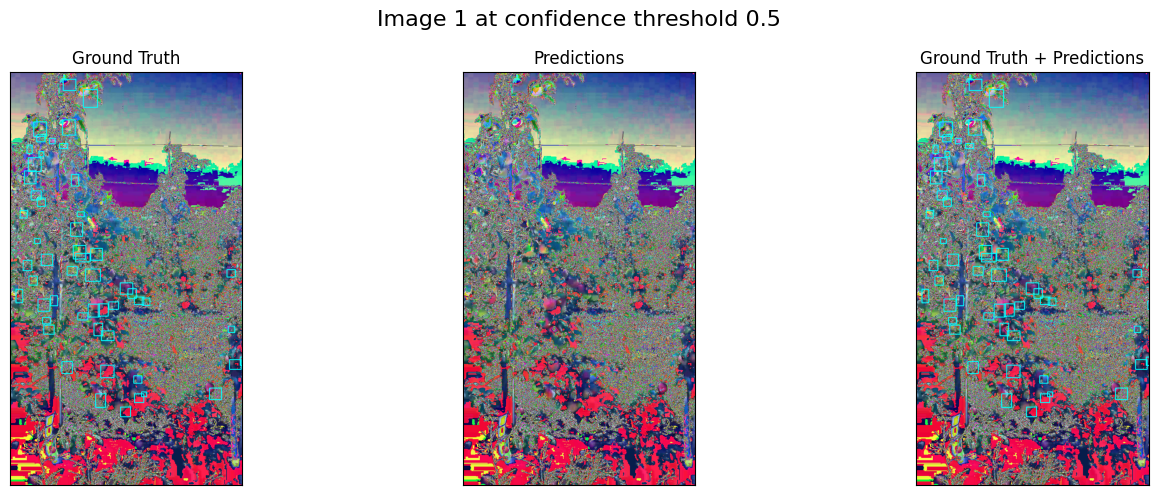

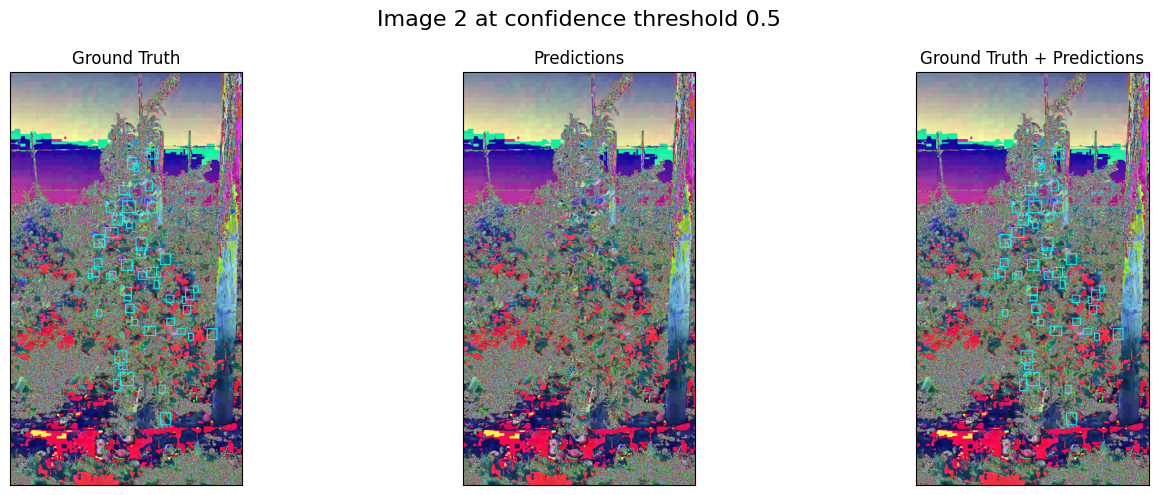

In [41]:
visualise_predictions(faster_rcnn_model, val_loader, val_dataset, {0: 'background', 1: 'fruit'}, num_images=2, confidence_threshold=0.5)